<div class="alert alert-block alert-success">
    <h1>
        Example notebook - Finance fraud detection
    </h1>
    <p>
        Link to dataset : <a href="https://www.kaggle.com/datasets/ealaxi/paysim1">Link to Kaggle dataset</a>
    </p>
</div>

# Financial Payment Fraud Detection using TuringDB

## Executive Summary

### Dataset Overview
- **Source**: PaySim Synthetic Financial Dataset
- **Period**: 30 days of mobile money transactions
- **Scale**: ~6.3 million transactions between customer and merchant accounts
- **Data**: Transaction amounts, types, timestamps, account balances, fraud labels

### Objectives
This notebook demonstrates how **TuringDB's graph database** can be used to detect fraudulent patterns in financial payment networks. We showcase multiple fraud detection techniques:

1. **Hub Analysis** - Identify suspicious accounts with unusual connectivity patterns
2. **Transfer-CashOut Pattern Detection** - Find classic fraud sequences (mule accounts)
3. **Fan-out/Fan-in Patterns** - Detect money laundering and account takeover behaviors
4. **Rapid Movement Analysis** - Find suspicious fast-moving transaction chains
5. **Balance Integrity Analysis** - Detect impossible account balance transitions
6. **Velocity Analysis** - Identify abnormal transaction frequency patterns
7. **Cross-Analysis Risk Scoring** - Combine multiple signals for comprehensive fraud detection

### Key Capabilities Demonstrated
- Graph ingestion from CSV data (6M+ transactions)
- Multi-hop path queries for transaction chains
- Temporal analysis with time-based filtering
- Transaction type-based pattern detection
- Balance anomaly detection
- Pattern-based fraud detection with ground truth validation
- Multi-signal risk scoring and prioritization

### Why Graph Databases for Fraud Detection?
Traditional relational databases struggle with:
- Multi-hop relationship queries requiring complex self-joins
- Path finding through transaction chains
- Network topology analysis
- Combining structural and temporal patterns

**TuringDB excels at:**
- Fast traversal of connected transaction data
- Natural representation of money flows through accounts
- Scalable pattern matching across millions of transactions
- Intuitive query language for complex fraud patterns

### PaySim Dataset Details
The PaySim dataset simulates mobile money transactions based on real-world patterns from a financial service in Africa:

- **Transaction Types**: 
  - PAYMENT: Paying merchants
  - TRANSFER: Sending money to another customer
  - CASH_OUT: Withdrawing cash
  - DEBIT: Direct debits
  - CASH_IN: Depositing cash
  
- **Fraud Labels**: ~0.13% fraud rate (8,213 confirmed fraudulent transactions)
- **Balance Tracking**: Before/after balances for both sender and receiver
- **Temporal Data**: Hour-by-hour transaction timestamps (744 time steps)

### Financial Fraud Patterns We Detect

1. **Transfer-CashOut Chains**: 
   - Money transferred from victim to intermediary (mule account)
   - Immediate cash-out by mule to exit the system
   - Graph pattern: `Account_A --TRANSFER--> Account_B --CASH_OUT--> Exit`

2. **Money Mule Networks**:
   - Accounts receiving from many sources (fan-in)
   - Then distributing to many destinations (fan-out)
   - Central nodes in fraud networks

3. **Account Takeover**:
   - Sudden burst of transactions to multiple recipients
   - Rapid dispersal pattern (fan-out)
   - Often followed by account dormancy

4. **Balance Anomalies**:
   - Negative account balances
   - Balance changes not matching transaction amounts
   - Impossible state transitions

5. **Velocity Attacks**:
   - Abnormally high transaction frequency
   - Multiple transactions in very short time windows
   - Exceeding normal behavioral patterns

# Import modules and functions

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import re
import time
warnings.filterwarnings('ignore')

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

# Check data files are available

In [3]:
example_name = "paysim_financial_fraud_detection"
path_data = f"{os.getcwd()}/data/{example_name}"
if not os.path.exists(path_data):
    raise ValueError(f"{path_data} does not exist")

list_csv_files = sorted(os.listdir(path_data))
if not "PS_20174392719_1491204439457_log.csv" in list_csv_files:
    print(f"PaySim CSV file is not available in {path_data}. \n")
    if not os.path.exists(f"{path_data}/paysim1.zip"):
        print(
            f"Downloading from: https://www.kaggle.com/datasets/ealaxi/paysim1"
            "\n...\n"
        )
        os.system(f"curl -L -o {path_data}/paysim1.zip https://www.kaggle.com/api/v1/datasets/download/ealaxi/paysim1")
    os.system(f"unzip {path_data}/paysim1.zip -d {path_data}")

PaySim CSV file is not available in /home/dev/turingdb-examples/examples/notebooks/public_version/data/paysim_financial_fraud_detection. 

...



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  177M  100  177M    0     0  30.8M      0  0:00:05  0:00:05 --:--:-- 38.2M


Archive:  /home/dev/turingdb-examples/examples/notebooks/public_version/data/paysim_financial_fraud_detection/paysim1.zip
  inflating: /home/dev/turingdb-examples/examples/notebooks/public_version/data/paysim_financial_fraud_detection/PS_20174392719_1491204439457_log.csv  


# Data Loading & Initial Exploration

## Load dataset

In [4]:
# Load the PaySim dataset
df_raw = pd.read_csv(f"{path_data}/PS_20174392719_1491204439457_log.csv")
print(df_raw.shape)

print("="*80)
print(" DATASET OVERVIEW")
print("="*80)
print(f"Total transactions: {len(df_raw):,}")
print(f"Time range: Step {df_raw['step'].min()} to {df_raw['step'].max()} (hours)")
print(f"Duration: {df_raw['step'].max() / 24:.1f} days")
print(f"Columns: {list(df_raw.columns)}")
print(f"\nFirst few rows:")
display(df_raw.head())

print(f"\nBasic statistics:")
display(pd.DataFrame(df_raw.dtypes, columns=["types"]))
display(df_raw.describe())

(6362620, 11)
 DATASET OVERVIEW
Total transactions: 6,362,620
Time range: Step 1 to 743 (hours)
Duration: 31.0 days
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

First few rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



Basic statistics:


,types
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,int64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Dataset Schema Explanation

In [5]:
print("="*80)
print(" COLUMN DESCRIPTIONS")
print("="*80)
print("""
PaySim Dataset Schema:
----------------------
step          : Time step (1 step = 1 hour, max 744 = 31 days)
type          : Transaction type (PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN)
amount        : Transaction amount in local currency
nameOrig      : Customer ID who initiated the transaction
oldbalanceOrg : Initial balance before transaction (origin account)
newbalanceOrig: New balance after transaction (origin account)
nameDest      : Recipient ID
oldbalanceDest: Initial balance before transaction (destination account)
newbalanceDest: New balance after transaction (destination account)
isFraud       : Ground truth fraud label (1=fraud, 0=legitimate)
isFlaggedFraud: System flagged as potential fraud (transfers > 200,000)
""")

 COLUMN DESCRIPTIONS

PaySim Dataset Schema:
----------------------
step          : Time step (1 step = 1 hour, max 744 = 31 days)
type          : Transaction type (PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN)
amount        : Transaction amount in local currency
nameOrig      : Customer ID who initiated the transaction
oldbalanceOrg : Initial balance before transaction (origin account)
newbalanceOrig: New balance after transaction (origin account)
nameDest      : Recipient ID
oldbalanceDest: Initial balance before transaction (destination account)
newbalanceDest: New balance after transaction (destination account)
isFraud       : Ground truth fraud label (1=fraud, 0=legitimate)
isFlaggedFraud: System flagged as potential fraud (transfers > 200,000)



## Transaction Type Distribution

 TRANSACTION TYPE ANALYSIS

Transaction Type Distribution:
  CASH_OUT    :  2,237,500 (35.17%)
  PAYMENT     :  2,151,495 (33.81%)
  CASH_IN     :  1,399,284 (21.99%)
  TRANSFER    :    532,909 ( 8.38%)
  DEBIT       :     41,432 ( 0.65%)


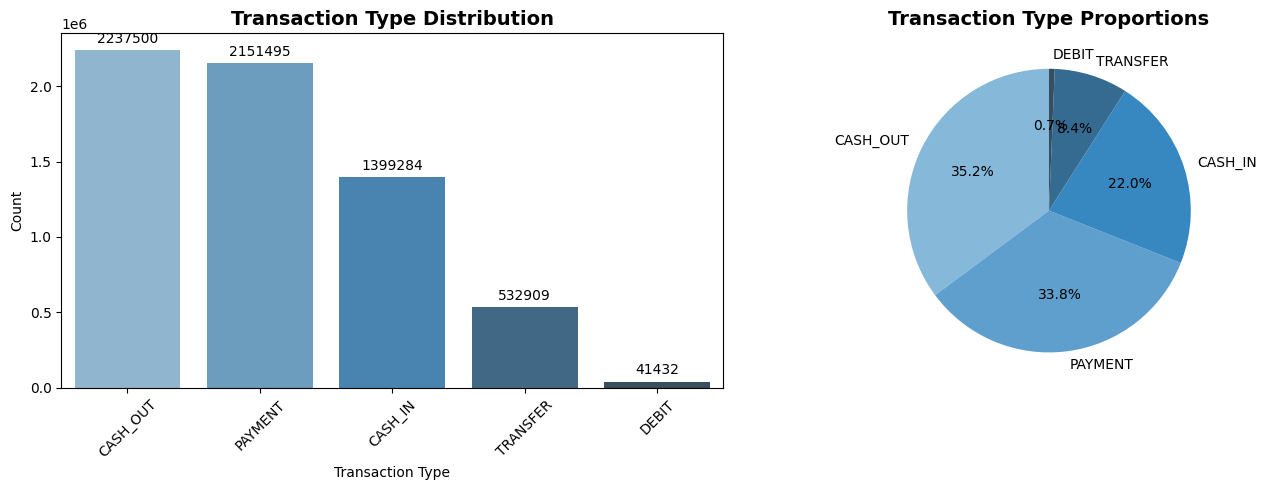

In [6]:
print("="*80)
print(" TRANSACTION TYPE ANALYSIS")
print("="*80)

# Transaction type distribution
type_counts = df_raw['type'].value_counts()
type_percentages = df_raw['type'].value_counts(normalize=True) * 100

print("\nTransaction Type Distribution:")
for txn_type in type_counts.index:
    count = type_counts[txn_type]
    pct = type_percentages[txn_type]
    print(f"  {txn_type:12s}: {count:>10,} ({pct:>5.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart with seaborn
sns.barplot(x=type_counts.index, y=type_counts.values, ax=axes[0], palette='Blues_d')
axes[0].set_title('Transaction Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', padding=3)

# Pie chart
axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('Blues_d', len(type_counts)))
axes[1].set_title('Transaction Type Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Fraud Statistics

 FRAUD ANALYSIS

Overall Fraud Statistics:
  Total fraud cases: 8,213
  Fraud rate: 0.1291%
  Flagged by system: 16
  Detection rate: 0.19%

Transaction Type Total Count     Fraud Count     Fraud Rate     
------------------------------------------------------------
PAYMENT         2,151,495       0               0.0000         %
TRANSFER        532,909         4,097           0.7688         %
CASH_OUT        2,237,500       4,116           0.1840         %
DEBIT           41,432          0               0.0000         %
CASH_IN         1,399,284       0               0.0000         %


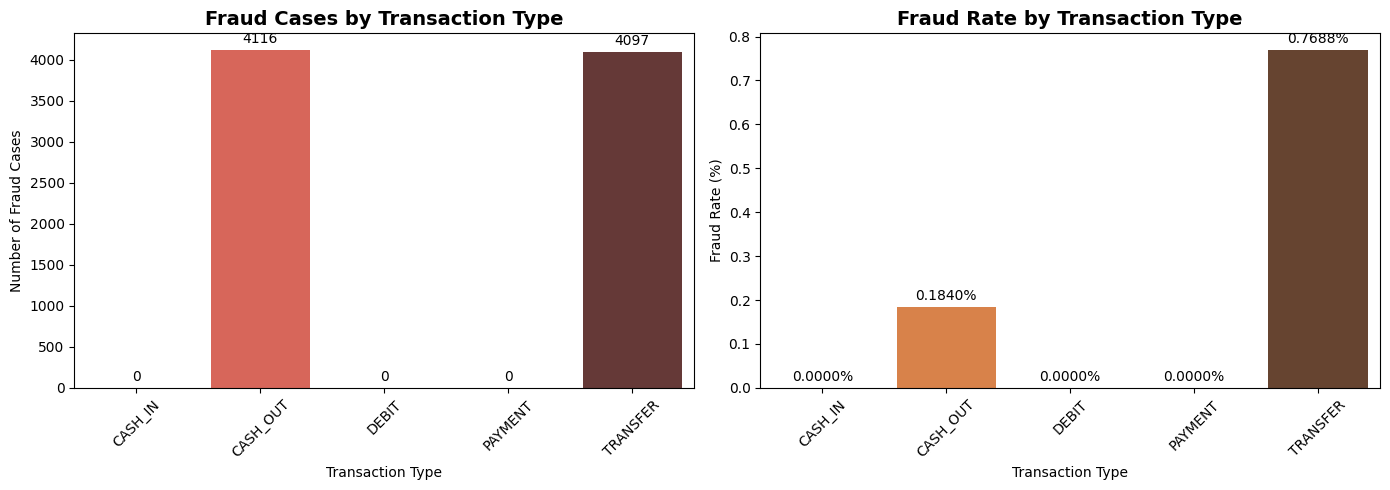

In [7]:
print("="*80)
print(" FRAUD ANALYSIS")
print("="*80)

total_fraud = df_raw['isFraud'].sum()
fraud_rate = df_raw['isFraud'].mean() * 100
flagged_fraud = df_raw['isFlaggedFraud'].sum()

print(f"\nOverall Fraud Statistics:")
print(f"  Total fraud cases: {total_fraud:,}")
print(f"  Fraud rate: {fraud_rate:.4f}%")
print(f"  Flagged by system: {flagged_fraud:,}")
print(f"  Detection rate: {(flagged_fraud / total_fraud * 100) if total_fraud > 0 else 0:.2f}%")

# Fraud by transaction type
print(f"\n{'Transaction Type':<15} {'Total Count':<15} {'Fraud Count':<15} {'Fraud Rate':<15}")
print("-" * 60)
for txn_type in df_raw['type'].unique():
    type_df = df_raw[df_raw['type'] == txn_type]
    total = len(type_df)
    fraud = type_df['isFraud'].sum()
    rate = (fraud / total * 100) if total > 0 else 0
    print(f"{txn_type:<15} {total:<15,} {fraud:<15,} {rate:<15.4f}%")

# Visualize fraud by type
fraud_by_type = df_raw.groupby('type')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_type['fraud_rate'] = fraud_by_type['mean'] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fraud counts
sns.barplot(x=fraud_by_type.index, y=fraud_by_type['sum'], ax=axes[0], palette='Reds_d')
axes[0].set_title('Fraud Cases by Transaction Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Number of Fraud Cases')
axes[0].tick_params(axis='x', rotation=45)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', padding=3)

# Fraud rates
sns.barplot(x=fraud_by_type.index, y=fraud_by_type['fraud_rate'], ax=axes[1], palette='Oranges_d')
axes[1].set_title('Fraud Rate by Transaction Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Transaction Type')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.4f%%', padding=3)

plt.tight_layout()
plt.show()

## Amount Distribution Analysis

 AMOUNT DISTRIBUTION ANALYSIS

Amount Statistics:
count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64


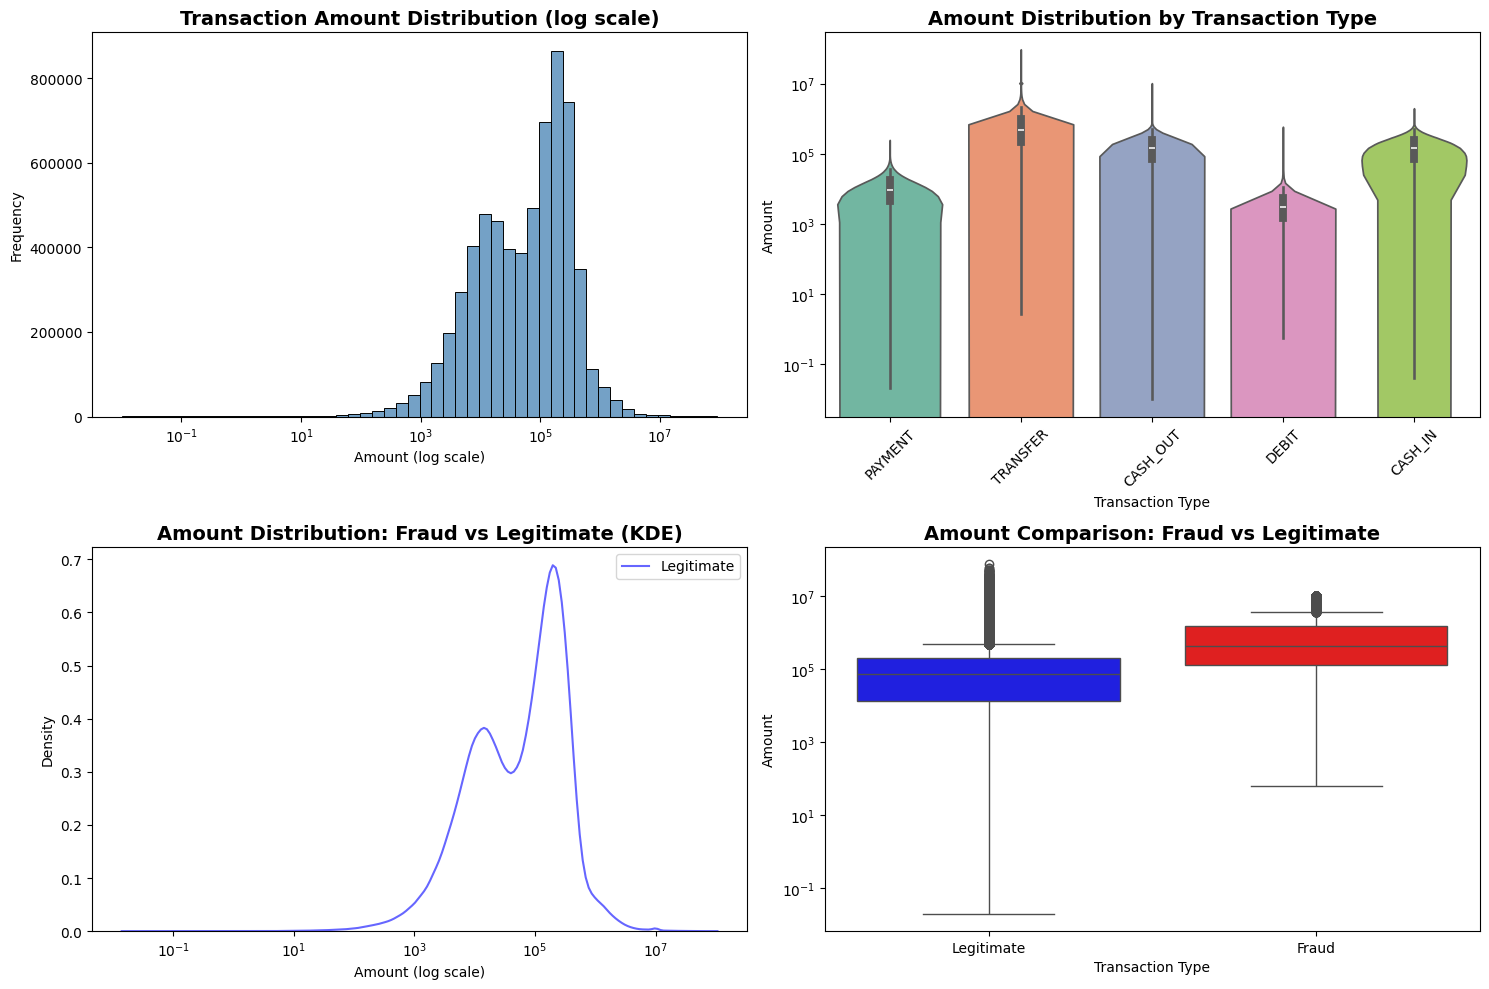

In [8]:
print("="*80)
print(" AMOUNT DISTRIBUTION ANALYSIS")
print("="*80)

print("\nAmount Statistics:")
print(df_raw['amount'].describe())

# Visualize amounts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall amount distribution (log scale)
sns.histplot(data=df_raw[df_raw['amount'] > 0], x='amount', bins=50, 
             ax=axes[0, 0], color='steelblue', log_scale=(True, False))
axes[0, 0].set_title('Transaction Amount Distribution (log scale)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Amount (log scale)')
axes[0, 0].set_ylabel('Frequency')

# Amount by type (violin plot)
sns.violinplot(data=df_raw[df_raw['amount'] > 0], x='type', y='amount', 
               ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Amount Distribution by Transaction Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Transaction Type')
axes[0, 1].set_ylabel('Amount')
axes[0, 1].set_yscale('log')
axes[0, 1].tick_params(axis='x', rotation=45)

# Fraud vs Legitimate amounts (KDE)
fraud_df = df_raw[df_raw['isFraud'] == 1]
legit_df = df_raw[df_raw['isFraud'] == 0].sample(min(len(fraud_df) * 100, len(df_raw)))

sns.kdeplot(data=legit_df, x='amount', ax=axes[1, 0], 
            label='Legitimate', color='blue', alpha=0.6, log_scale=True)
sns.kdeplot(data=fraud_df, x='amount', ax=axes[1, 0], 
            label='Fraud', color='red', alpha=0.6, log_scale=True)
axes[1, 0].set_title('Amount Distribution: Fraud vs Legitimate (KDE)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Amount (log scale)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()

# Box plot comparison
comparison_df = pd.concat([
    legit_df[['amount']].assign(type='Legitimate'),
    fraud_df[['amount']].assign(type='Fraud')
])
sns.boxplot(data=comparison_df[comparison_df['amount'] > 0], 
            x='type', y='amount', ax=axes[1, 1], palette=['blue', 'red'])
axes[1, 1].set_title('Amount Comparison: Fraud vs Legitimate', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Transaction Type')
axes[1, 1].set_ylabel('Amount')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

## Temporal Patterns

 TEMPORAL PATTERN ANALYSIS

Time Statistics:
  Total time steps: 743
  Average transactions per hour: 8563
  Peak hour transactions: 51,352
  Peak occurred at step: 19


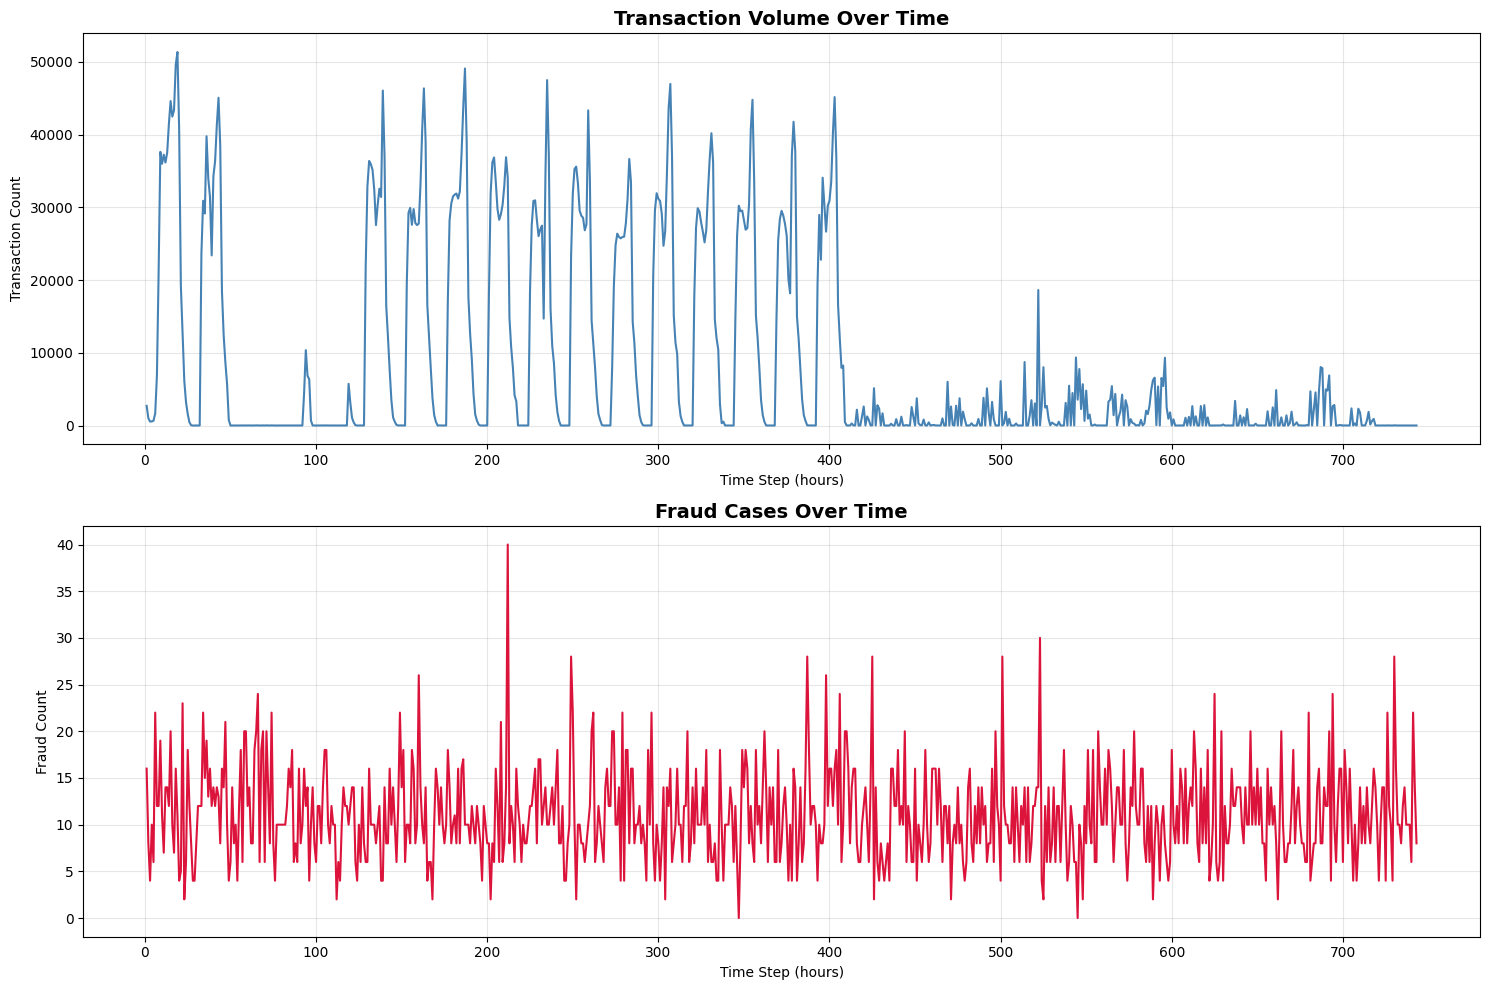

In [9]:
print("="*80)
print(" TEMPORAL PATTERN ANALYSIS")
print("="*80)

# Transaction volume over time
time_dist = df_raw.groupby('step').size().reset_index(name='count')
fraud_time = df_raw.groupby('step')['isFraud'].sum().reset_index(name='fraud_count')

print(f"\nTime Statistics:")
print(f"  Total time steps: {df_raw['step'].max()}")
print(f"  Average transactions per hour: {time_dist['count'].mean():.0f}")
print(f"  Peak hour transactions: {time_dist['count'].max():,}")
print(f"  Peak occurred at step: {time_dist.loc[time_dist['count'].idxmax(), 'step']}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Transaction volume
sns.lineplot(data=time_dist, x='step', y='count', ax=axes[0], color='steelblue', linewidth=1.5)
axes[0].set_title('Transaction Volume Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Step (hours)')
axes[0].set_ylabel('Transaction Count')
axes[0].grid(alpha=0.3)

# Fraud volume
sns.lineplot(data=fraud_time, x='step', y='fraud_count', ax=axes[1], color='crimson', linewidth=1.5)
axes[1].set_title('Fraud Cases Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Step (hours)')
axes[1].set_ylabel('Fraud Count')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Graph Creation in TuringDB

# Graph Schema Design for Financial Fraud Detection

## Schema Choice: Bipartite Transaction-Centric Model

We'll use a bipartite graph structure that separates accounts and transactions as distinct node types:
```
Nodes:
  Account {id, type: 'customer'|'merchant'}
  Transaction {id, amount, type, step, is_fraud, is_flagged}

Edges:
  SENT: Account -> Transaction (oldbalance, newbalance)
  RECEIVED: Transaction -> Account (oldbalance, newbalance)
```

### Visualization of Schema
```
[Account:C123] --SENT--> [Transaction:TX456] --RECEIVED--> [Account:C789]
                         {amount: 1000}
                         {type: TRANSFER}
                         {step: 48}
```

### Why This Schema?

**Advantages:**
1. **Natural pattern matching**: Easy to express multi-hop queries
   - Example: Find accounts involved in Transfer-CashOut chains
   - Query: `Account -SENT-> Txn1 -RECEIVED-> Account -SENT-> Txn2`

2. **Transaction as first-class entity**: 
   - Can filter by transaction type mid-path
   - Can analyze transaction properties independently
   - Example: "Find TRANSFER transactions followed by CASH_OUT"

3. **Balance tracking**: 
   - Edge properties store balance changes
   - Can detect impossible balance transitions
   - Can track money flow with precision

4. **Flexible fraud detection**:
   - Account-centric: Find suspicious accounts
   - Transaction-centric: Find suspicious transaction patterns
   - Path-centric: Find suspicious money flow chains

### Alternative Schema (Not Used)

Direct account-to-account edges:
```
Account -[TRANSACTED {amount, type, step}]-> Account
```

**Why we don't use it:**
- Loses transaction-level granularity
- Harder to query "all TRANSFER transactions followed by CASH_OUT"
- Cannot easily distinguish multiple transactions between same accounts
- Less natural for fraud pattern queries

### Performance Considerations

**Node counts:**
- Accounts: ~50,000 (customers + merchants)
- Transactions: ~6,300,000
- Total nodes: ~6,350,000

**Edge counts:**
- SENT edges: ~6,300,000 (one per transaction)
- RECEIVED edges: ~6,300,000 (one per transaction)
- Total edges: ~12,600,000

**Batching strategy** (due to TuringDB v1 1MB query limit):
- Account nodes: 10,000 per batch
- Transaction nodes: 5,000 per batch
- Edges: 5,000 per batch
- Memory-efficient: Process in chunks to avoid loading entire dataset

## Build Targeted Dataset with Mule Accounts (ensure interesting paths are created)

In [10]:
print("="*80)
print(" BUILDING TARGETED DATASET WITH TRANSFER-CASHOUT PATTERNS")
print("="*80)

# Get potential mule accounts
transfers = df_raw[df_raw['type'] == 'TRANSFER']
cashouts = df_raw[df_raw['type'] == 'CASH_OUT']

transfer_recipients = set(transfers['nameDest'].unique())
cashout_senders = set(cashouts['nameOrig'].unique())
potential_mules = list(transfer_recipients & cashout_senders)

print(f"\nFound {len(potential_mules):,} potential mule accounts")

# Strategy: Build a focused dataset around these mules
# Include:
# 1. All transfers TO these mules
# 2. All cashouts FROM these mules  
# 3. Some context transactions for each mule

targeted_transactions = []

for mule in potential_mules[:100]:  # Take first 100 mules to ensure we have patterns
    # Get transfers to this mule
    transfers_to_mule = transfers[transfers['nameDest'] == mule]
    
    # Get cashouts from this mule
    cashouts_from_mule = cashouts[cashouts['nameOrig'] == mule]
    
    # Add these transactions
    targeted_transactions.append(transfers_to_mule)
    targeted_transactions.append(cashouts_from_mule)
    
    # Also add some surrounding context (transfers from the source accounts)
    for source_account in transfers_to_mule['nameOrig'].unique():
        source_txns = df_raw[df_raw['nameOrig'] == source_account].head(5)
        targeted_transactions.append(source_txns)
    
    # And cashout destinations context
    for dest_account in cashouts_from_mule['nameDest'].unique():
        dest_txns = df_raw[df_raw['nameDest'] == dest_account].head(5)
        targeted_transactions.append(dest_txns)

# Combine and deduplicate
df_targeted = pd.concat(targeted_transactions, ignore_index=True).drop_duplicates(subset=['step', 'nameOrig', 'nameDest', 'amount'])

print(f"\nTargeted dataset created:")
print(f"  Total transactions: {len(df_targeted):,}")
print(f"  Unique accounts: {pd.concat([df_targeted['nameOrig'], df_targeted['nameDest']]).nunique():,}")
print(f"  TRANSFER transactions: {(df_targeted['type'] == 'TRANSFER').sum():,}")
print(f"  CASH_OUT transactions: {(df_targeted['type'] == 'CASH_OUT').sum():,}")

# Verify patterns exist
transfers_targeted = df_targeted[df_targeted['type'] == 'TRANSFER']
cashouts_targeted = df_targeted[df_targeted['type'] == 'CASH_OUT']

transfer_recipients_targeted = set(transfers_targeted['nameDest'].unique())
cashout_senders_targeted = set(cashouts_targeted['nameOrig'].unique())
mules_in_targeted = transfer_recipients_targeted & cashout_senders_targeted

print(f"\n✓ Guaranteed mule accounts in targeted dataset: {len(mules_in_targeted):,}")

# Show some examples
print(f"\nExample patterns that will exist:")
for mule in list(mules_in_targeted)[:5]:
    t_in = transfers_targeted[transfers_targeted['nameDest'] == mule]
    c_out = cashouts_targeted[cashouts_targeted['nameOrig'] == mule]
    print(f"  {mule}: {len(t_in)} transfers in → {len(c_out)} cashouts out")

 BUILDING TARGETED DATASET WITH TRANSFER-CASHOUT PATTERNS

Found 249 potential mule accounts

Targeted dataset created:
  Total transactions: 736
  Unique accounts: 836
  TRANSFER transactions: 265
  CASH_OUT transactions: 357

✓ Guaranteed mule accounts in targeted dataset: 100

Example patterns that will exist:
  C413334326: 3 transfers in → 1 cashouts out
  C1023330867: 1 transfers in → 1 cashouts out
  C1445395724: 4 transfers in → 1 cashouts out
  C1574995118: 1 transfers in → 1 cashouts out
  C1654501817: 2 transfers in → 1 cashouts out


## Build Cypher CREATE Command Function

In [11]:
def build_cypher_create_commands_less1MB(df, max_size_mb=1):
    """
    Build Cypher CREATE command for TuringDB v1 (no MATCH support).
    Creates Account and Transaction nodes, then SENT and RECEIVED edges.
    Outputs a SINGLE CREATE statement with comma-separated patterns.
    
    Schema:
        - Account nodes: {id, type: 'customer'|'merchant'}
        - Transaction nodes: {id, amount, type, step, is_fraud, is_flagged}
        - SENT edges: Account -> Transaction {oldbalance, newbalance}
        - RECEIVED edges: Transaction -> Account {oldbalance, newbalance}
    
    Args:
        df: DataFrame with PaySim columns (step, type, amount, nameOrig, oldbalanceOrg, 
                                           newbalanceOrig, nameDest, oldbalanceDest, 
                                           newbalanceDest, isFraud, isFlaggedFraud, txn_id)
        max_size_mb: Maximum size in MB (default 1MB)
    
    Returns:
        str: Single Cypher CREATE command with comma-separated patterns
    """
    import pandas as pd
    
    max_bytes = max_size_mb * 1000 * 1000 * 0.9999
    
    account_nodes = {}  # account_id -> variable name
    txn_nodes = {}      # txn_id -> variable name
    
    patterns = []  # Store patterns (nodes and edges)
    current_size = len("CREATE ".encode('utf-8'))  # Account for initial "CREATE "
    
    for idx, row in df.iterrows():
        # Origin Account node
        orig_id = str(row['nameOrig'])
        if orig_id not in account_nodes:
            var_name = f"a{len(account_nodes)}"
            account_nodes[orig_id] = var_name
            
            # Determine account type
            acc_type = 'merchant' if orig_id.startswith('M') else 'customer'
            
            pattern = f'({var_name}:Account {{"id":"{orig_id}", "type":"{acc_type}"}})'
            
            # Check if adding this pattern exceeds limit
            pattern_size = len(pattern.encode('utf-8')) + 2  # +2 for ",\n"
            if current_size + pattern_size > max_bytes:
                break
            
            patterns.append(pattern)
            current_size += pattern_size
        
        # Destination Account node
        dest_id = str(row['nameDest'])
        if dest_id not in account_nodes:
            var_name = f"a{len(account_nodes)}"
            account_nodes[dest_id] = var_name
            
            # Determine account type
            acc_type = 'merchant' if dest_id.startswith('M') else 'customer'
            
            pattern = f'({var_name}:Account {{"id":"{dest_id}", "type":"{acc_type}"}})'
            
            # Check if adding this pattern exceeds limit
            pattern_size = len(pattern.encode('utf-8')) + 2
            if current_size + pattern_size > max_bytes:
                break
            
            patterns.append(pattern)
            current_size += pattern_size
        
        # Transaction node
        txn_id = row['txn_id']
        if txn_id not in txn_nodes:
            var_name = f"t{len(txn_nodes)}"
            txn_nodes[txn_id] = var_name
            
            pattern = f'''({var_name}:Transaction {{"id":"{txn_id}", "amount":{float(row['amount'])}, "type":"{row['type']}", "step":{int(row['step'])}, "is_fraud":{int(row['isFraud'])}, "is_flagged":{int(row['isFlaggedFraud'])}}})'''
            
            # Check if adding this pattern exceeds limit
            pattern_size = len(pattern.encode('utf-8')) + 2
            if current_size + pattern_size > max_bytes:
                break
            
            patterns.append(pattern)
            current_size += pattern_size
        
        # Only add edges if all nodes are in the graph
        if orig_id in account_nodes and dest_id in account_nodes and txn_id in txn_nodes:
            # SENT edge: Account -> Transaction
            sent_pattern = f'({account_nodes[orig_id]})-[:SENT {{"oldbalance":{float(row["oldbalanceOrg"])}, "newbalance":{float(row["newbalanceOrig"])}}}]-({txn_nodes[txn_id]})'
            
            pattern_size = len(sent_pattern.encode('utf-8')) + 2
            if current_size + pattern_size > max_bytes:
                break
            
            patterns.append(sent_pattern)
            current_size += pattern_size
            
            # RECEIVED edge: Transaction -> Account
            recv_pattern = f'({txn_nodes[txn_id]})-[:RECEIVED {{"oldbalance":{float(row["oldbalanceDest"])}, "newbalance":{float(row["newbalanceDest"])}}}]-({account_nodes[dest_id]})'
            
            pattern_size = len(recv_pattern.encode('utf-8')) + 2
            if current_size + pattern_size > max_bytes:
                break
            
            patterns.append(recv_pattern)
            current_size += pattern_size
    
    # Build single CREATE command with comma-separated patterns
    cypher_command = "CREATE " + ",\n".join(patterns)
    
    n_accounts = len(account_nodes)
    n_txns = len(txn_nodes)
    n_sent = len([p for p in patterns if ':SENT' in p])
    n_recv = len([p for p in patterns if ':RECEIVED' in p])
    
    print(f"✓ Cypher query will create graph with:")
    print(f"    {n_accounts:,} Account nodes")
    print(f"    {n_txns:,} Transaction nodes")
    print(f"    {n_sent:,} SENT edges")
    print(f"    {n_recv:,} RECEIVED edges")
    print(f"✓ Total size: {len(cypher_command.encode('utf-8')) / 1000:.1f} KB")
    
    return cypher_command

print("Function build_cypher_create_commands_less1MB() defined successfully")

Function build_cypher_create_commands_less1MB() defined successfully


## Build Cypher CREATE Commands

In [12]:
print("\n" + "="*80)
print(" CREATING GRAPH WITH TARGETED DATASET")
print("="*80)

# Add transaction IDs if not present
if 'txn_id' not in df_targeted.columns:
    df_targeted['txn_id'] = ['TX' + str(i) for i in range(len(df_targeted))]

# Build Cypher command
print("\nGenerating Cypher CREATE command for targeted dataset...")
graph_CREATE_command = build_cypher_create_commands_less1MB(df_targeted, max_size_mb=1)

print(f"\nCommand preview (first 500 chars):")
print(graph_CREATE_command[:500] + "...\n")


 CREATING GRAPH WITH TARGETED DATASET

Generating Cypher CREATE command for targeted dataset...
✓ Cypher query will create graph with:
    836 Account nodes
    736 Transaction nodes
    736 SENT edges
    736 RECEIVED edges
✓ Total size: 233.1 KB

Command preview (first 500 chars):
CREATE (a0:Account {"id":"C358945953", "type":"customer"}),
(a1:Account {"id":"C413334326", "type":"customer"}),
(t0:Transaction {"id":"TX0", "amount":47579.03, "type":"TRANSFER", "step":253, "is_fraud":0, "is_flagged":0}),
(a0)-[:SENT {"oldbalance":0.0, "newbalance":0.0}]-(t0),
(t0)-[:RECEIVED {"oldbalance":449391.27, "newbalance":496970.3}]-(a1),
(a2:Account {"id":"C467636308", "type":"customer"}),
(t1:Transaction {"id":"TX1", "amount":719426.44, "type":"TRANSFER", "step":328, "is_fraud":0, "i...



In [13]:
#print("="*80)
#print(" BUILDING GRAPH IN TURINGDB")
#print("="*80)
#
## Add transaction IDs if not already present
#if 'txn_id' not in df_raw.columns:
#    df_raw['txn_id'] = ['TX' + str(i) for i in range(len(df_raw))]
#
## Generate Cypher CREATE command
#print("\nGenerating Cypher CREATE command...")
#graph_CREATE_command = build_cypher_create_commands_less1MB(df_raw, max_size_mb=1)
#
#print(f"\nFirst 500 characters of command:")
#print(graph_CREATE_command[:500] + "...")

# Create graph using `turingdb` python package

<div class="alert alert-block alert-info">
    <h2>
        See <a href="https://docs.turingdb.ai/quickstart">TuringDB Get started documentation</a> for the important steps to follow :
    </h2>
    <h3>
        <ul>
            <li>Create your TuringDB account</li>
            <li>Create your instance in the <a href="https://console.turingdb.ai/auth">TuringDB Cloud UI</a></li>
            <li>Copy your Instance ID from the Database Instances management page</li>
            <li>Get API Key from the Settings in UI</li>
        </ul>
        Remember to have your instance active while working in this notebook !
    </h3>
</div>

In [14]:
from turingdb import TuringDB

# Create TuringDB client
client = TuringDB(
    host="http://localhost:6666"  # Remove this parameter and set the two parameters below
    # instance_id=os.getenv("INSTANCE_ID"),
    # auth_token=os.getenv("AUTH_TOKEN"),
)

In [15]:
%%time

client.s3_connect(
    bucket_name="turing-internal",
    region="eu-west-2",
    access_key=os.getenv("AWS_ACCESS_KEY"),
    secret_key=os.getenv("AWS_SECRET_KEY"),
)

CPU times: user 114 ms, sys: 48 ms, total: 162 ms
Wall time: 251 ms


In [16]:
# Get list of loaded graphs
list_graphs = client.list_loaded_graphs()
list_graphs

['default']

In [19]:
# Set graph name
graph_name_prefix = example_name
graph_name_nb_suffix = str(
    max(
        [
            int(re.sub(graph_name_prefix, "", g))
            for g in list_graphs
            if g.startswith(graph_name_prefix)
            and re.sub(graph_name_prefix, "", g).isdigit()
        ]
        + [0]
    )
    + 1
)
graph_name = graph_name_prefix + graph_name_nb_suffix
graph_name = re.sub("-", "_", graph_name)
print(f"graph_name: {graph_name}")

graph_name: paysim_financial_fraud_detection1


In [20]:
from turingdb.exceptions import TuringDBException

In [21]:
%%time

# Set graph
try:
    client.create_graph(graph_name)
except TuringDBException as e:
    print(e)

# Set working graph
client.set_graph(graph_name)

CPU times: user 2.05 ms, sys: 2 ms, total: 4.05 ms
Wall time: 12.1 ms


In [22]:
%%time

# Create a new change on the graph
client.checkout()
change = client.new_change()
print(f"Current change {change}")

# Checkout into the change
client.checkout(change=change)

Current change 0
CPU times: user 3.77 ms, sys: 0 ns, total: 3.77 ms
Wall time: 2.67 ms


In [26]:
%%time

# Run CREATE command
print("\nExecuting query on TuringDB...")
start_time = time.time()
result = client.query(graph_CREATE_command)
execution_time = time.time() - start_time
print(f"✓ Graph created successfully in {execution_time:.2f} seconds")

# Commit the change
client.query("COMMIT")
client.query("CHANGE SUBMIT")

# Checkout into main
client.checkout()


Executing query on TuringDB...
✓ Graph created successfully in 0.05 seconds
CPU times: user 4.36 ms, sys: 2.01 ms, total: 6.37 ms
Wall time: 109 ms


# Query TuringDB

## Use metaqueries to have insight on graph overall structure

<h3>
    To learn more about 📮 Metaqueries, please check TuringDB documentation on this <a href="https://turingdb.mintlify.app/query/cypher_subset#%F0%9F%93%AE-metaqueries">link</a>
</h3>

In [27]:
%%time

# CALL PROPERTIES() - returns a column of all the different node and edge properties and their types in the database
command = """
CALL PROPERTIES()
"""
df_PROPERTIES = client.query(command)
if df_PROPERTIES.empty:
    print("No result found")
else:
    df_PROPERTIES.columns = ["Property_ID", "Property_name", "Property_type"]
    display(df_PROPERTIES)

,Property_ID,Property_name,Property_type
0,0,id,String
1,1,type,String
2,2,amount,Double
3,3,step,Int64
4,4,is_fraud,Int64
5,5,is_flagged,Int64
6,6,oldbalance,Double
7,7,newbalance,Double


CPU times: user 6.71 ms, sys: 2 ms, total: 8.71 ms
Wall time: 6.83 ms


In [28]:
# Get node properties
nodes_properties = df_PROPERTIES["Property_name"].values.tolist()
print(f"Node properties: {nodes_properties}")

Node properties: ['id', 'type', 'amount', 'step', 'is_fraud', 'is_flagged', 'oldbalance', 'newbalance']


In [29]:
%%time

# CALL LABELS () - returns a column of all the different node labels
command = """
CALL LABELS()
"""
df_LABELS = client.query(command)
if df_LABELS.empty:
    print("No result found")
else:
    df_LABELS.columns = ["Node_type_ID", "Node_label"]
    display(df_LABELS)

,Node_type_ID,Node_label
0,0,Account
1,1,Transaction


CPU times: user 6.76 ms, sys: 1.98 ms, total: 8.74 ms
Wall time: 7.3 ms


In [30]:
%%time

# CALL EDGETYPES() - returns a column of all the different edge types (edge equivalent of node labels)
command = """
CALL EDGETYPES()
"""
df_EDGETYPES = client.query(command)
if df_EDGETYPES.empty:
    print("No result found")
else:
    df_EDGETYPES.columns = ["Edge_type_ID", "Edge_label"]
    display(df_EDGETYPES)

,Edge_type_ID,Edge_label
0,0,SENT
1,1,RECEIVED


CPU times: user 4.69 ms, sys: 3.96 ms, total: 8.65 ms
Wall time: 7.18 ms


In [31]:
%%time

# CALL LABELSETS() - returns a two columns describing combinations of node labels
command = """
CALL LABELSETS()
"""
df_LABELSETS = client.query(command)
if df_LABELSETS.empty:
    print("No result found")
else:
    df_LABELSETS.columns = ["Node_type_ID", "Node_label"]
    display(df_LABELSETS)

,Node_type_ID,Node_label
0,0,Account
1,1,Transaction


CPU times: user 7.24 ms, sys: 1.02 ms, total: 8.26 ms
Wall time: 7.05 ms


In [32]:
%%time

# Find number of nodes and number of edges in the graph
n_nodes = len(client.query("MATCH (n) RETURN n"))
n_edges = len(client.query("MATCH (n)--(m) RETURN n, m"))
print(f"Graph: {n_nodes:,} nodes and {n_edges:,} edges")

Graph: 1,572 nodes and 1,472 edges
CPU times: user 3.66 ms, sys: 2.99 ms, total: 6.65 ms
Wall time: 5.03 ms


## Simple queries

In [33]:
from turingdb_examples.utils import get_return_statements

In [35]:
%%time

# Match all edges and return them
command = """
MATCH (n)-[e]-(m)
RETURN n.id, n.type, e, m.id, m.type
"""
df_all_edges = client.query(command)
if df_all_edges.empty:
    print("No result found")
else:
    df_all_edges.columns = get_return_statements(command)
    display(df_all_edges)

,n.id,n.type,e,m.id,m.type
0,C1958260831,customer,0,TX307,CASH_OUT
1,C693207385,customer,1,TX592,CASH_OUT
2,C1108687791,customer,2,TX308,CASH_OUT
3,C2048633894,customer,3,TX309,TRANSFER
4,C436378709,customer,4,TX312,CASH_OUT
...,...,...,...,...,...
1467,TX340,TRANSFER,1467,C19673653,customer
1468,TX341,CASH_OUT,1468,C1241266786,customer
1469,TX342,CASH_OUT,1469,C1241266786,customer
1470,TX343,CASH_IN,1470,C1241266786,customer


CPU times: user 18.8 ms, sys: 1.03 ms, total: 19.8 ms
Wall time: 18.5 ms


In [36]:
%%time

# Match all edges and return them
command = """
MATCH (a1:Account)--(t:Transaction)--(a2:Account)
RETURN a1.id, a1.type, t.amount, t.type, a2.id, a2.type, t.is_fraud
"""
df_all_transactions = client.query(command)
if df_all_transactions.empty:
    print("No result found")
else:
    df_all_transactions.columns = get_return_statements(command)
    display(df_all_transactions)

,a1.id,a1.type,t.amount,t.type,a2.id,a2.type,t.is_fraud
0,C1958260831,customer,119221.10,CASH_OUT,C1685108724,customer,0
1,C693207385,customer,172443.81,CASH_OUT,C2110337370,customer,0
2,C1108687791,customer,226056.34,CASH_OUT,C1685108724,customer,0
3,C2048633894,customer,141304.15,TRANSFER,C436378709,customer,0
4,C436378709,customer,331760.74,CASH_OUT,C1924726171,customer,0
...,...,...,...,...,...,...,...
731,C1061339446,customer,191537.44,CASH_OUT,C1595094870,customer,0
732,C1180111082,customer,173541.22,TRANSFER,C537010105,customer,0
733,C2006343394,customer,173551.27,CASH_OUT,C156595733,customer,0
734,C230788237,customer,26520.57,CASH_OUT,C1797827177,customer,0


CPU times: user 12 ms, sys: 989 μs, total: 13 ms
Wall time: 12.5 ms


<Axes: xlabel='t.is_fraud', ylabel='count'>

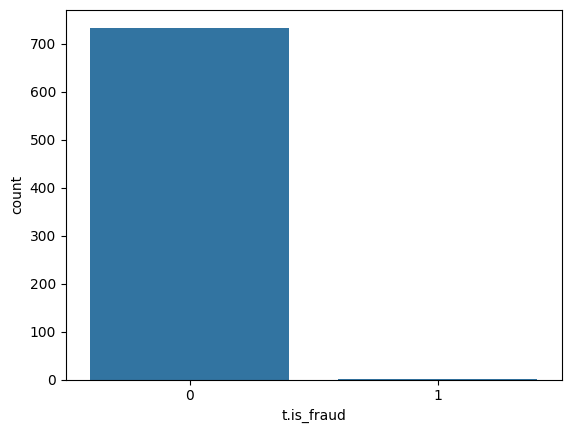

In [37]:
sns.countplot(df_all_transactions, x="t.is_fraud")


 FRAUD DISTRIBUTION IN ALL TRANSACTIONS

Transaction Fraud Statistics:
  Legitimate transactions: 734
  Fraudulent transactions: 2
  Fraud rate: 0.27%


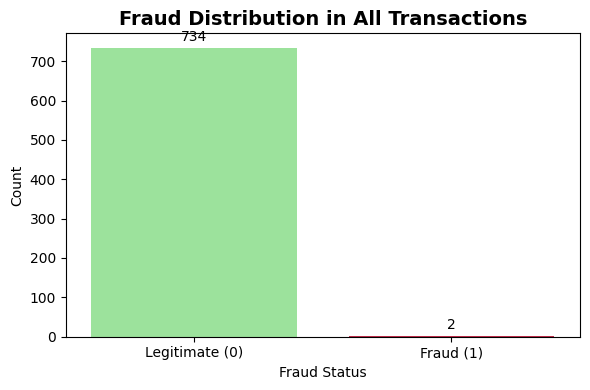

In [38]:
# If you have results from TuringDB stored in df_all_transactions
print("\n" + "="*80)
print(" FRAUD DISTRIBUTION IN ALL TRANSACTIONS")
print("="*80)

# Count fraud distribution
fraud_counts = df_all_transactions['t.is_fraud'].value_counts()
fraud_rate = df_all_transactions['t.is_fraud'].mean() * 100

print(f"\nTransaction Fraud Statistics:")
print(f"  Legitimate transactions: {fraud_counts.get(0, 0):,}")
print(f"  Fraudulent transactions: {fraud_counts.get(1, 0):,}")
print(f"  Fraud rate: {fraud_rate:.2f}%")

# Visualize
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(data=df_all_transactions, x='t.is_fraud', palette=['lightgreen', 'crimson'], ax=ax)
ax.set_title('Fraud Distribution in All Transactions', fontsize=14, fontweight='bold')
ax.set_xlabel('Fraud Status')
ax.set_ylabel('Count')
ax.set_xticklabels(['Legitimate (0)', 'Fraud (1)'])

# Add count labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

# Fraud Pattern Detection - Transfer-CashOut Chains

## Hub Analysis (High-Degree Nodes)

Identifies entities with high degree centrality (many connections). These could be:
- **Legitimate**: Exchanges, payment processors, mining pools
- **Suspicious**: Mixing services, tumblers, laundering hubs

In [39]:
def analyze_hubs(df, id_cols=None):
    """
    Post-process to find hub nodes from edge list.
    
    Args:
        df: DataFrame with columns 'n.entity_id' and 'other.entity_id'
    
    Returns:
        DataFrame with entity_id, degree, sorted by degree descending
    """
    import pandas as pd
    
    # Combine both columns to count all connections
    if id_cols is None:
        id_cols = ["n.id", "m.id"]
    all_entities = pd.concat([
        df[id_cols[0]], 
        df[id_cols[1]]
    ])
    
    # Count occurrences (degree)
    degree_counts = all_entities.value_counts().reset_index()
    degree_counts.columns = ['entity_id', 'degree']
    
    return degree_counts


def visualize_hubs(hubs, top_n=20):
    """
    Visualize hub analysis results.
    
    Args:
        hubs: DataFrame with 'entity_id' and 'degree' columns
        top_n: Number of top hubs to display
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    top_hubs = hubs.head(top_n)
    sns.barplot(data=top_hubs, x=top_hubs.index, y='degree', hue=top_hubs.index,
                palette='viridis', legend=False)
    plt.xlabel('Entity Rank', fontsize=12)
    plt.ylabel('Degree (Number of Connections)', fontsize=12)
    plt.title(f'Top {top_n} Hub Entities', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(top_n), top_hubs['entity_id'], rotation=90, fontsize=9)
    plt.tight_layout()
    plt.show()


def print_hub_statistics(hubs, percentile=0.95):
    """
    Print hub statistics and identify mixing suspects.
    
    Args:
        hubs: DataFrame with 'entity_id' and 'degree' columns
        percentile: Threshold percentile for flagging suspects (default 0.95 = top 5%)
    """
    print(f"\nHub Statistics:")
    print(f"Total unique entities: {len(hubs)}")
    print(f"Max degree: {hubs['degree'].max()}")
    print(f"Mean degree: {hubs['degree'].mean():.2f}")
    print(f"Median degree: {hubs['degree'].median():.2f}")
    
    high_degree_threshold = hubs['degree'].quantile(percentile)
    mixing_suspects = hubs[hubs['degree'] > high_degree_threshold]
    print(f"\nPotential mixing services (degree > {high_degree_threshold:.0f}):")
    display(mixing_suspects)
    
    return mixing_suspects

In [40]:
%%time

# Execute Hub Analysis
print("Performing hub analysis (excluding Entity 0)...")

# Query TuringDB
command = """
MATCH (a1:Account)--(t:Transaction)--(a2:Account)
RETURN a1.id, a1.type, t.amount, t.type, a2.id, a2.type, t.is_fraud
"""
df_analyze_hubs = client.query(command)
if df_analyze_hubs.empty:
    print("No result found")
else:
    df_analyze_hubs.columns = get_return_statements(command)
    #display(df_analyze_hubs)

if df_analyze_hubs.empty:
    print("No result found")
else:
    # Filter Entity 0 in post-processing
    df_analyze_hubs_clean = df_analyze_hubs[
        (df_analyze_hubs['a1.id'] != 0) & 
        (df_analyze_hubs['a2.id'] != 0)
    ]
    
    print(f"✓ Retrieved {len(df_analyze_hubs_clean):,} edges for analysis")
    #display(df_analyze_hubs_clean.head(10))

Performing hub analysis (excluding Entity 0)...
✓ Retrieved 736 edges for analysis
CPU times: user 3.13 ms, sys: 2.63 ms, total: 5.76 ms
Wall time: 5.08 ms



Top 20 Hub Nodes:


,entity_id,degree
0,C537010105,8
1,C1023072030,7
2,C1357618544,7
3,C1475849418,6
4,C235701501,6
5,C2110337370,6
6,C1868897118,6
7,C898665687,6
8,C1667170918,6
9,C207698497,6


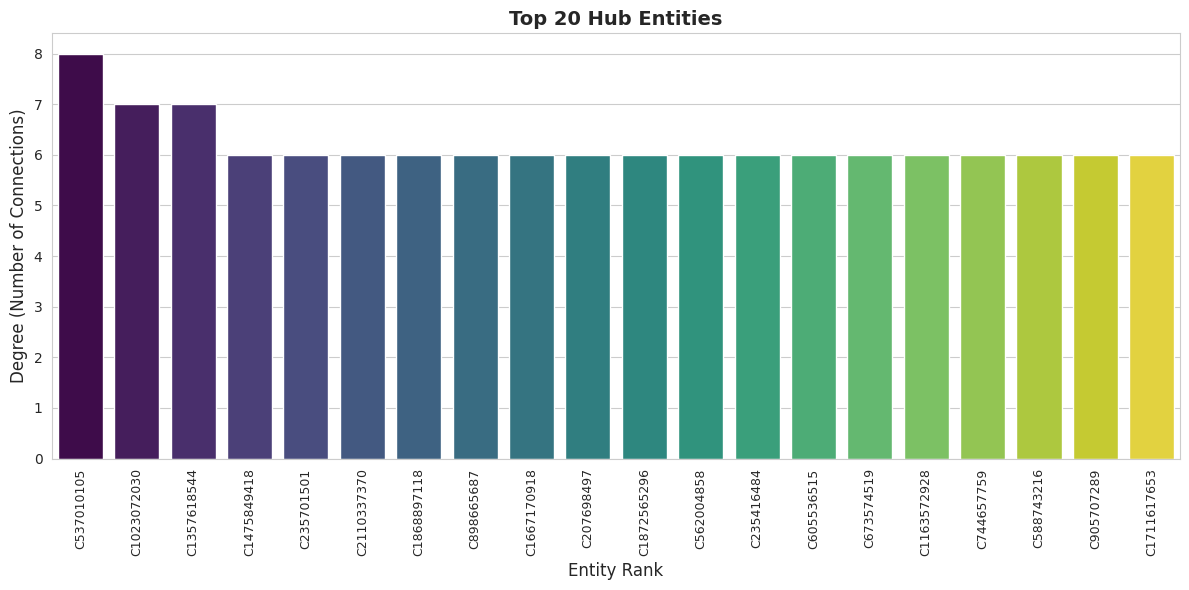


Hub Statistics:
Total unique entities: 836
Max degree: 8
Mean degree: 1.76
Median degree: 1.00

Potential mixing services (degree > 6):


,entity_id,degree
0,C537010105,8
1,C1023072030,7
2,C1357618544,7


CPU times: user 311 ms, sys: 6.02 ms, total: 317 ms
Wall time: 314 ms


In [41]:
%%time

# Analyze
hubs = analyze_hubs(df_analyze_hubs_clean, id_cols=["a1.id", "a2.id"])
print("\nTop 20 Hub Nodes:")
display(hubs.head(20))

# Visualize
visualize_hubs(hubs, top_n=20)

# Statistics
mixing_suspects = print_hub_statistics(hubs, percentile=0.95)

# Transfer-CashOut Pattern Detection

## Classic Fraud Pattern in Financial Systems

One of the most prevalent fraud patterns in payment networks:

### The Pattern
1. **Fraudster** initiates TRANSFER from compromised victim account
2. **Mule account** (intermediary) receives the funds
3. **Mule** immediately executes CASH_OUT to extract money from system
4. Money disappears, difficult to trace

### Graph Representation
```
Victim Account --TRANSFER--> Mule Account --CASH_OUT--> [Exit System]
     (C123)                      (C456)
```

### Why This Pattern Exists
- **Speed**: Fraudsters want money out quickly before detection
- **Obfuscation**: Using intermediary (mule) adds layer of separation
- **Cash-out**: Converts digital money to untraceable cash

### Detection Strategy

We'll identify:
1. **Direct patterns**: TRANSFER followed by CASH_OUT from same account
2. **Temporal constraint**: Very short time window (< 1 hour)
3. **Repeat offenders**: Accounts with multiple such patterns (confirmed mules)

### Graph Query Advantage

**SQL approach** (complex and slow):
```sql
SELECT t1.*, t2.*
FROM transactions t1
JOIN transactions t2 ON t1.dest_account = t2.source_account
WHERE t1.type = 'TRANSFER'
  AND t2.type = 'CASH_OUT'
  AND t2.timestamp > t1.timestamp
  AND t2.timestamp - t1.timestamp < 3600
```

**Graph approach** (natural and fast):
```cypher
MATCH (a1:Account)-[s:SENT]-(t1:Transaction)-[r:RECEIVED]-(a2:Account)
      -[s2:SENT]-(t2:Transaction)
RETURN a2.id AS mule_account, 
       t1.id AS transfer_id, 
       t2.id AS cashout_id,
       t2.step - t1.step AS time_diff
```

Then filter in pandas for transaction types and time constraints (since TuringDB v1 lacks WHERE).

In [42]:
#print("="*80)
#print(" VERIFYING TRANSFER-CASHOUT PATTERNS IN RAW DATA")
#print("="*80)
#
## Check if pattern exists in the dataset
#transfers = df_raw[df_raw['type'] == 'TRANSFER']
#cashouts = df_raw[df_raw['type'] == 'CASH_OUT']
#
#print(f"\nDataset statistics:")
#print(f"  Total transactions: {len(df_raw):,}")
#print(f"  TRANSFER transactions: {len(transfers):,}")
#print(f"  CASH_OUT transactions: {len(cashouts):,}")
#
## Check for potential mule accounts
## (accounts that both receive transfers and send cashouts)
#transfer_recipients = set(transfers['nameDest'].unique())
#cashout_senders = set(cashouts['nameOrig'].unique())
#potential_mules = transfer_recipients & cashout_senders
#
#print(f"\nPotential intermediate accounts (mules):")
#print(f"  Accounts receiving transfers: {len(transfer_recipients):,}")
#print(f"  Accounts sending cashouts: {len(cashout_senders):,}")
#print(f"  Overlap (potential mules): {len(potential_mules):,}")
#
#if len(potential_mules) > 0:
#    print(f"\n✓ Pattern CAN exist in dataset!")
#    print(f"  Building graph with these accounts should reveal Transfer-CashOut chains")
#    
#    # Sample a few potential mules
#    sample_mules = list(potential_mules)[:5]
#    print(f"\nSample potential mule accounts: {sample_mules}")
#    
#    # Check their activity
#    for mule in sample_mules[:3]:
#        transfers_in = transfers[transfers['nameDest'] == mule]
#        cashouts_out = cashouts[cashouts['nameOrig'] == mule]
#        print(f"\n  Account {mule}:")
#        print(f"    Received {len(transfers_in)} transfers (total: ${transfers_in['amount'].sum():,.2f})")
#        print(f"    Made {len(cashouts_out)} cashouts (total: ${cashouts_out['amount'].sum():,.2f})")
#else:
#    print(f"\n⚠ No overlapping accounts found!")
#    print(f"  Transfer-CashOut pattern may not exist in this dataset")
#    print(f"  Consider using a larger sample or different fraud pattern")

## Detect transfer-cashout patterns

In [43]:
print("="*80)
print(" DETECTING TRANSFER-CASHOUT PATTERNS")
print("="*80)

# TuringDB Cypher query to find 2-hop transaction chains
cypher_pattern_query = """
MATCH (a1:Account)-[s1:SENT]-(t1:Transaction)-[r1:RECEIVED]-(a2:Account)
      -[s2:SENT]-(t2:Transaction)-[r2:RECEIVED]-(a3:Account)
RETURN a1.id, a2.id, a3.id, t1.id, t1.type, t1.amount, t1.step, t1.is_fraud , t2.id, t2.type, t2.amount, t2.step, t2.is_fraud 
"""
# TODO with TuringDB v2: filter out negative time difference -> keep where t1.step < t2.step

print("Cypher query for 2-hop transaction chains:")
print(cypher_pattern_query)

# In production, execute this query:
#patterns_raw = client.query(cypher_pattern_query)
df_patterns_raw = client.query(cypher_pattern_query)
if df_patterns_raw.empty:
    print("No result found")
else:
    df_patterns_raw.columns = get_return_statements(cypher_pattern_query)
    #display(df_analyze_hubs)
display(df_patterns_raw)

 DETECTING TRANSFER-CASHOUT PATTERNS
Cypher query for 2-hop transaction chains:

MATCH (a1:Account)-[s1:SENT]-(t1:Transaction)-[r1:RECEIVED]-(a2:Account)
      -[s2:SENT]-(t2:Transaction)-[r2:RECEIVED]-(a3:Account)
RETURN a1.id, a2.id, a3.id, t1.id, t1.type, t1.amount, t1.step, t1.is_fraud , t2.id, t2.type, t2.amount, t2.step, t2.is_fraud 



,a1.id,a2.id,a3.id,t1.id,t1.type,t1.amount,t1.step,t1.is_fraud,t2.id,t2.type,t2.amount,t2.step,t2.is_fraud
0,C2048633894,C436378709,C1924726171,TX309,TRANSFER,141304.15,164,0,TX312,CASH_OUT,331760.74,374,0
1,C1292201352,C436378709,C1924726171,TX310,TRANSFER,267712.47,209,0,TX312,CASH_OUT,331760.74,374,0
2,C322893228,C436378709,C1924726171,TX311,TRANSFER,855539.29,354,0,TX312,CASH_OUT,331760.74,374,0
3,C1557923130,C652516766,C2110337370,TX590,TRANSFER,370633.61,350,0,TX591,CASH_OUT,145074.37,282,0
4,C850680951,C652516766,C2110337370,TX589,TRANSFER,1425683.47,303,0,TX591,CASH_OUT,145074.37,282,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,C1156918136,C1413602216,C2061483625,TX214,TRANSFER,616468.15,661,0,TX215,CASH_OUT,124863.91,202,0
210,C527710401,C116646707,C1423108740,TX155,TRANSFER,114720.99,231,0,TX158,CASH_OUT,100498.48,331,0
211,C812066336,C537010105,C18661163,TX147,TRANSFER,472479.38,34,0,TX152,CASH_OUT,141935.32,252,0
212,C1180111082,C537010105,C18661163,TX145,TRANSFER,173541.22,11,0,TX152,CASH_OUT,141935.32,252,0


## Process Query Results

In [47]:
print("="*80)
print(" ANALYZING TIME DIFFERENCES (CORRECTED)")
print("="*80)

# Rename columns for clarity
df_patterns_raw.columns = [
    'source_account', 'intermediate_account', 'destination_account',
    'txn1_id', 'txn1_type', 'txn1_amount', 'txn1_step', 'txn1_fraud',
    'txn2_id', 'txn2_type', 'txn2_amount', 'txn2_step', 'txn2_fraud'
]

print(f"✓ Retrieved {len(df_patterns_raw):,} 2-hop patterns from TuringDB")
print(f"\nPattern distribution by transaction types:")
print(df_patterns_raw.groupby(['txn1_type', 'txn2_type']).size().reset_index(name='count'))

# Keep rows having required design TRANSFER then CASHOUT
transfer_cashout = df_patterns_raw[
    (df_patterns_raw['txn1_type'] == 'TRANSFER') &
    (df_patterns_raw['txn2_type'] == 'CASH_OUT')
].copy()

print(f"Total 2-hop patterns from query: {len(df_patterns_raw):,}")
print(f"Transfer-CashOut type combinations: {len(transfer_cashout):,}")

# Calculate time difference
transfer_cashout['time_diff'] = transfer_cashout['txn2_step'] - transfer_cashout['txn1_step']

print(f"\nTime difference statistics (all patterns):")
print(transfer_cashout['time_diff'].describe())

print(f"\nTime difference distribution:")
print(f"  Negative (cashout before transfer): {(transfer_cashout['time_diff'] < 0).sum():,}")
print(f"  Zero (same time): {(transfer_cashout['time_diff'] == 0).sum():,}")
print(f"  Positive (cashout after transfer): {(transfer_cashout['time_diff'] > 0).sum():,}")

 ANALYZING TIME DIFFERENCES (CORRECTED)
✓ Retrieved 214 2-hop patterns from TuringDB

Pattern distribution by transaction types:
  txn1_type txn2_type  count
0  TRANSFER  CASH_OUT    214
Total 2-hop patterns from query: 214
Transfer-CashOut type combinations: 214

Time difference statistics (all patterns):
count    214.000000
mean     -23.574766
std      192.805532
min     -681.000000
25%     -138.500000
50%      -24.500000
75%      113.000000
max      383.000000
Name: time_diff, dtype: float64

Time difference distribution:
  Negative (cashout before transfer): 119
  Zero (same time): 1
  Positive (cashout after transfer): 94


## Visualize time differences

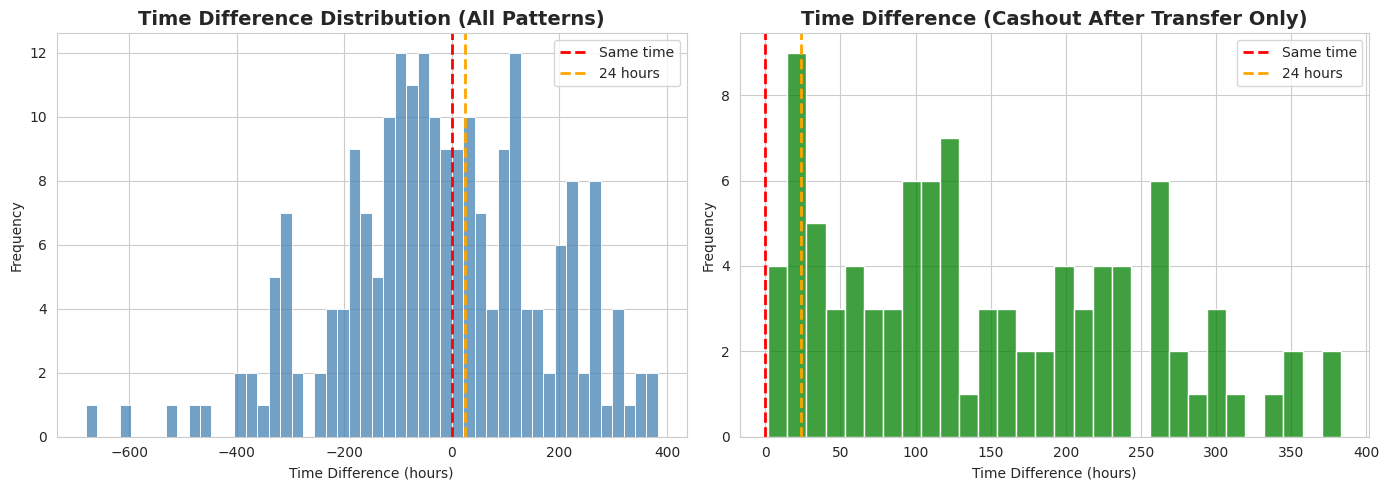


Positive time difference statistics:
count     94.000000
mean     146.361702
std      100.922183
min        2.000000
25%       61.500000
50%      121.500000
75%      222.500000
max      383.000000
Name: time_diff, dtype: float64

Percentiles (positive only):
    1.0th:     2.00 hours
   10.0th:    23.60 hours
   25.0th:    61.50 hours
   50.0th:   121.50 hours
   75.0th:   222.50 hours
   90.0th:   279.70 hours
   95.0th:   317.80 hours
   99.0th:   373.70 hours


In [48]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution including negatives
sns.histplot(data=transfer_cashout, x='time_diff', bins=50, ax=axes[0], color='steelblue')
axes[0].set_title('Time Difference Distribution (All Patterns)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Difference (hours)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Same time')
axes[0].axvline(24, color='orange', linestyle='--', linewidth=2, label='24 hours')
axes[0].legend()

# Only positive time differences
positive_diffs = transfer_cashout[transfer_cashout['time_diff'] > 0]
if len(positive_diffs) > 0:
    sns.histplot(data=positive_diffs, x='time_diff', bins=30, ax=axes[1], color='green')
    axes[1].set_title('Time Difference (Cashout After Transfer Only)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time Difference (hours)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Same time')
    axes[1].axvline(24, color='orange', linestyle='--', linewidth=2, label='24 hours')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'No chronological patterns found', 
                ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nPositive time difference statistics:")
if len(positive_diffs) > 0:
    print(positive_diffs['time_diff'].describe())
    
    percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    print(f"\nPercentiles (positive only):")
    for p in percentiles:
        val = positive_diffs['time_diff'].quantile(p)
        print(f"  {p*100:>5.1f}th: {val:>8.2f} hours")
else:
    print("  No positive time differences found!")

## Analyse all tranfer-cashout patterns

In [49]:
print("\n" + "="*80)
print(" ANALYZING ALL TRANSFER-CASHOUT PATTERNS")
print("="*80)

# For fraud detection, we can analyze the pattern existence regardless of exact timing
# The fact that these accounts do BOTH transfers and cashouts is suspicious

print(f"\nPattern Analysis (ignoring temporal order):")
print(f"  Total Transfer-CashOut patterns: {len(transfer_cashout):,}")
print(f"  Unique intermediate accounts (mules): {transfer_cashout['intermediate_account'].nunique():,}")
print(f"  Unique source accounts: {transfer_cashout['source_account'].nunique():,}")
print(f"  Unique destination accounts: {transfer_cashout['destination_account'].nunique():,}")

# Amount statistics
print(f"\nAmount Statistics:")
print(f"  Median transfer amount: ${transfer_cashout['txn1_amount'].median():,.2f}")
print(f"  Median cashout amount: ${transfer_cashout['txn2_amount'].median():,.2f}")
print(f"  Total transfers: ${transfer_cashout['txn1_amount'].sum():,.2f}")
print(f"  Total cashouts: ${transfer_cashout['txn2_amount'].sum():,.2f}")

# Fraud statistics
print(f"\nFraud Statistics:")
print(f"  Fraudulent transfers: {transfer_cashout['txn1_fraud'].sum():,}")
print(f"  Fraudulent cashouts: {transfer_cashout['txn2_fraud'].sum():,}")
patterns_with_fraud = ((transfer_cashout['txn1_fraud'] == 1) | (transfer_cashout['txn2_fraud'] == 1)).sum()
print(f"  Patterns with any fraud: {patterns_with_fraud:,} ({patterns_with_fraud/len(transfer_cashout)*100:.2f}%)")

# Categorize by time relationship
print(f"\nTemporal Patterns:")
print(f"  Cashout before transfer: {(transfer_cashout['time_diff'] < 0).sum():,}")
print(f"  Same time: {(transfer_cashout['time_diff'] == 0).sum():,}")
print(f"  Cashout after transfer (0-24h): {((transfer_cashout['time_diff'] > 0) & (transfer_cashout['time_diff'] <= 24)).sum():,}")
print(f"  Cashout after transfer (24-168h): {((transfer_cashout['time_diff'] > 24) & (transfer_cashout['time_diff'] <= 168)).sum():,}")
print(f"  Cashout after transfer (>168h): {(transfer_cashout['time_diff'] > 168).sum():,}")

# Use absolute time difference for visualization
#transfer_cashout['abs_time_diff'] = transfer_cashout['time_diff'].abs()
transfer_cashout['is_fraud'] = (
    (transfer_cashout['txn1_fraud'] == 1) | 
    (transfer_cashout['txn2_fraud'] == 1)
).astype(int)


 ANALYZING ALL TRANSFER-CASHOUT PATTERNS

Pattern Analysis (ignoring temporal order):
  Total Transfer-CashOut patterns: 214
  Unique intermediate accounts (mules): 100
  Unique source accounts: 213
  Unique destination accounts: 101

Amount Statistics:
  Median transfer amount: $482,750.07
  Median cashout amount: $150,440.10
  Total transfers: $148,338,864.29
  Total cashouts: $41,466,831.65

Fraud Statistics:
  Fraudulent transfers: 1
  Fraudulent cashouts: 0
  Patterns with any fraud: 1 (0.47%)

Temporal Patterns:
  Cashout before transfer: 119
  Same time: 1
  Cashout after transfer (0-24h): 10
  Cashout after transfer (24-168h): 48
  Cashout after transfer (>168h): 36


## Mule account analysis

In [50]:
print("\n" + "="*80)
print(" MULE ACCOUNT ANALYSIS")
print("="*80)

# Analyze intermediate accounts (mules)
mule_analysis = transfer_cashout.groupby('intermediate_account').agg({
    'txn1_id': 'count',
    'txn1_amount': 'sum',
    'txn2_amount': 'sum',
    'txn1_fraud': 'sum',
    'txn2_fraud': 'sum',
    'time_diff': 'mean'
}).reset_index()

mule_analysis.columns = [
    'account_id', 'pattern_count', 'total_transfer_in', 'total_cashout', 
    'transfer_frauds', 'cashout_frauds', 'avg_time_diff'
]

# Calculate fraud rate
mule_analysis['fraud_rate'] = (
    (mule_analysis['transfer_frauds'] + mule_analysis['cashout_frauds']) / 
    (mule_analysis['pattern_count'] * 2)
) * 100

# Sort by pattern count
mule_analysis = mule_analysis.sort_values('pattern_count', ascending=False)

print(f"\nMule Account Distribution:")
print(f"  Total mule accounts: {len(mule_analysis):,}")
print(f"  Accounts with 1 pattern: {(mule_analysis['pattern_count'] == 1).sum():,}")
print(f"  Accounts with 2-4 patterns: {((mule_analysis['pattern_count'] >= 2) & (mule_analysis['pattern_count'] <= 4)).sum():,}")
print(f"  Accounts with 5+ patterns: {(mule_analysis['pattern_count'] >= 5).sum():,}")
print(f"  Accounts with 10+ patterns: {(mule_analysis['pattern_count'] >= 10).sum():,}")

print(f"\nTop 20 Suspected Mule Accounts:")
print(mule_analysis.head(20).to_string(index=False))

# High-risk mules (multiple patterns + high fraud rate)
high_risk_mules = mule_analysis[
    (mule_analysis['pattern_count'] >= 3) & 
    (mule_analysis['fraud_rate'] >= 50)
]

if len(high_risk_mules) > 0:
    print(f"\n⚠ HIGH RISK MULES (3+ patterns, 50%+ fraud rate):")
    print(f"  Found {len(high_risk_mules):,} high-risk accounts")
    print(f"\nTop 10 highest risk:")
    print(high_risk_mules.head(10).to_string(index=False))


 MULE ACCOUNT ANALYSIS

Mule Account Distribution:
  Total mule accounts: 100
  Accounts with 1 pattern: 48
  Accounts with 2-4 patterns: 42
  Accounts with 5+ patterns: 10
  Accounts with 10+ patterns: 0

Top 20 Suspected Mule Accounts:
 account_id  pattern_count  total_transfer_in  total_cashout  transfer_frauds  cashout_frauds  avg_time_diff  fraud_rate
 C537010105              7         6520879.01      993547.24                0               0      83.714286         0.0
C1023072030              6         7241279.89       10194.12                0               0     -75.333333         0.0
C1357618544              6         8337239.99     1121723.58                0               0     116.000000         0.0
 C148758304              5         2668393.62     1359424.15                0               0     191.200000         0.0
C2108096804              5         2499156.37      125869.20                0               0     131.400000         0.0
 C678000776              5         

## Visualize transfer-cashout patterns


 VISUALIZING TRANSFER-CASHOUT PATTERNS


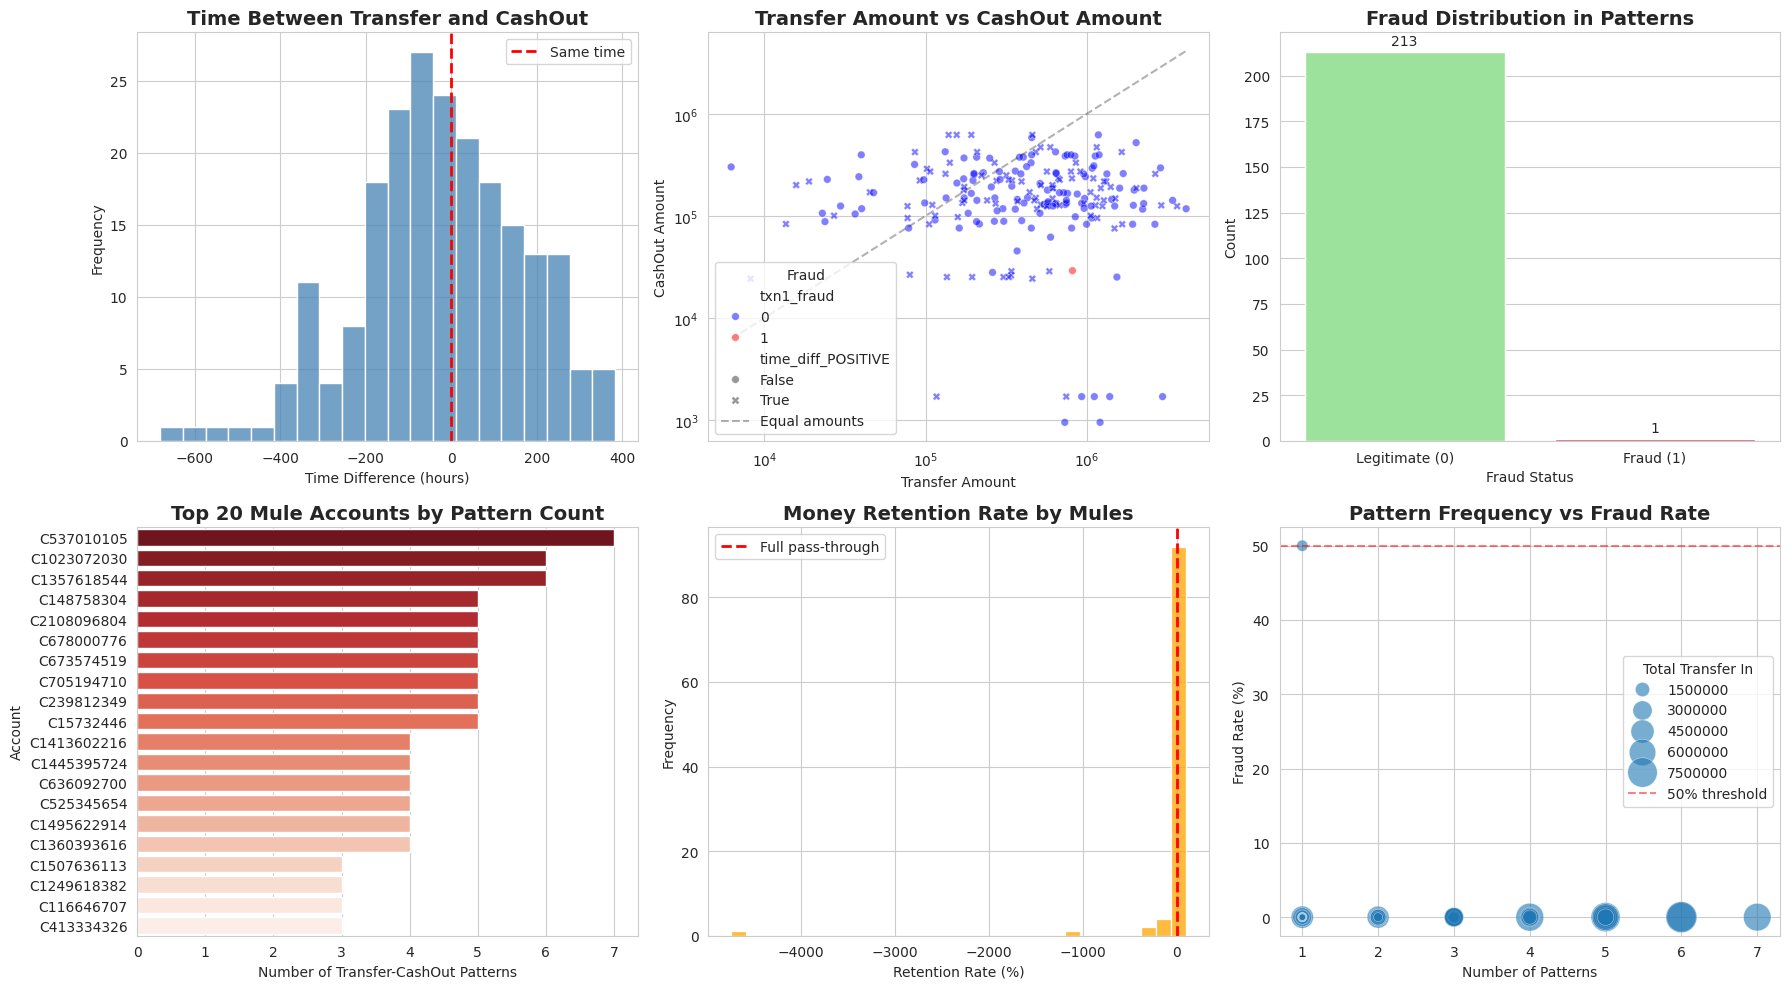


 KEY INSIGHTS
✓ 120 patterns occur within 30 minutes (56.1%)
✓ 1 patterns involve confirmed fraud (0.5%)
✓ Top mule account has 7 Transfer-CashOut patterns
✓ Average retention rate: -21.07%


In [51]:
print("\n" + "="*80)
print(" VISUALIZING TRANSFER-CASHOUT PATTERNS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Time difference distribution
sns.histplot(data=transfer_cashout, x='time_diff', bins=20, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Time Between Transfer and CashOut', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time Difference (hours)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0.0, color='red', linestyle='--', linewidth=2, label='Same time')
axes[0, 0].legend()

# 2. Transfer vs CashOut amounts
sample_size = min(5000, len(transfer_cashout))
sample = transfer_cashout.sample(sample_size) if len(transfer_cashout) > sample_size else transfer_cashout
sample["time_diff_POSITIVE"] = sample["time_diff"] > 0

sns.scatterplot(data=sample, x='txn1_amount', y='txn2_amount', 
                hue='txn1_fraud', palette={0: 'blue', 1: 'red'}, 
                style='time_diff_POSITIVE',
                alpha=0.5, ax=axes[0, 1], s=30)
axes[0, 1].plot([sample['txn1_amount'].min(), sample['txn1_amount'].max()], 
                [sample['txn1_amount'].min(), sample['txn1_amount'].max()], 
                'k--', alpha=0.3, label='Equal amounts')
axes[0, 1].set_title('Transfer Amount vs CashOut Amount', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Transfer Amount')
axes[0, 1].set_ylabel('CashOut Amount')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].legend(title='Fraud')

# 3. Fraud distribution
transfer_cashout['is_fraud'] = (
    (transfer_cashout['txn1_fraud'] == 1) | 
    (transfer_cashout['txn2_fraud'] == 1)
).astype(int)

sns.countplot(data=transfer_cashout, x='is_fraud', palette=['lightgreen', 'crimson'], ax=axes[0, 2])
axes[0, 2].set_title('Fraud Distribution in Patterns', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Fraud Status')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_xticklabels(['Legitimate (0)', 'Fraud (1)'])
for container in axes[0, 2].containers:
    axes[0, 2].bar_label(container, fmt='%d', padding=3)

# 4. Mule pattern frequency
if len(mule_analysis) >= 20:
    top_mules = mule_analysis.head(20)
    sns.barplot(data=top_mules, y="account_id", x='pattern_count',  # y=top_mules.index
                palette='Reds_r', ax=axes[1, 0], orient='h')
    axes[1, 0].set_title('Top 20 Mule Accounts by Pattern Count', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Transfer-CashOut Patterns')
    axes[1, 0].set_ylabel('Account')
else:
    sns.barplot(data=mule_analysis, x=mule_analysis.index, y='pattern_count', 
                palette='Reds_r', ax=axes[1, 0])
    axes[1, 0].set_title('Mule Accounts by Pattern Count', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Patterns')
    axes[1, 0].set_xlabel('Account')
    axes[1, 0].tick_params(axis='x', rotation=90)

# 5. Amount retained by mules
mule_analysis['amount_retained'] = mule_analysis['total_transfer_in'] - mule_analysis['total_cashout']
mule_analysis['retention_rate'] = (mule_analysis['amount_retained'] / mule_analysis['total_transfer_in']) * 100

sns.histplot(data=mule_analysis, x='retention_rate', bins=30, ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Money Retention Rate by Mules', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Retention Rate (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Full pass-through')
axes[1, 1].legend()

# 6. Pattern count vs fraud rate
if len(mule_analysis) > 0:
    sns.scatterplot(data=mule_analysis, x='pattern_count', y='fraud_rate', 
                    size='total_transfer_in', sizes=(20, 500), alpha=0.6, ax=axes[1, 2])
    axes[1, 2].set_title('Pattern Frequency vs Fraud Rate', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Number of Patterns')
    axes[1, 2].set_ylabel('Fraud Rate (%)')
    axes[1, 2].axhline(50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    axes[1, 2].legend(title='Total Transfer In', loc='best')

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "="*80)
print(" KEY INSIGHTS")
print("="*80)
fast_patterns = transfer_cashout[transfer_cashout['time_diff'] <= 0.5]
print(f"✓ {len(fast_patterns):,} patterns occur within 30 minutes ({len(fast_patterns)/len(transfer_cashout)*100:.1f}%)")
print(f"✓ {transfer_cashout['is_fraud'].sum():,} patterns involve confirmed fraud ({transfer_cashout['is_fraud'].mean()*100:.1f}%)")
print(f"✓ Top mule account has {mule_analysis.iloc[0]['pattern_count']:.0f} Transfer-CashOut patterns")
print(f"✓ Average retention rate: {mule_analysis['retention_rate'].mean():.2f}%")
if len(high_risk_mules) > 0:
    print(f"✓ {len(high_risk_mules):,} high-risk mule accounts identified (3+ patterns, 50%+ fraud)")

# Fan-Out and Fan-In Pattern Detection

## Pattern Definitions

**Fan-Out (Dispersal)**: One account sends to many accounts in short time
- Indicates: Account takeover, money laundering, smurfing

**Fan-In (Collection)**: One account receives from many accounts in short time  
- Indicates: Money mule, consolidation point, fraud hub

**Combined Pattern**: Accounts with both behaviors are highest risk

## Detect Fan-Out Patterns

In [52]:
print("="*80)
print(" DETECTING FAN-OUT PATTERNS (RAPID DISPERSAL)")
print("="*80)

# Query accounts sending to multiple destinations
cypher_fanout = """
MATCH (a:Account)-[s:SENT]-(t:Transaction)
RETURN a.id, t.id, t.step, t.amount, t.type
"""

# Execute query
# fanout_raw = client.query(cypher_fanout)

# Process in pandas to find fan-out patterns
# Group by account and time window
TIME_WINDOW = 24  # hours
MIN_TRANSACTIONS = 5

# Simulate with df_targeted
fanout_data = df_targeted.groupby('nameOrig').apply(
    lambda x: pd.Series({
        'num_transactions': len(x),
        'unique_destinations': x['nameDest'].nunique(),
        'time_span': x['step'].max() - x['step'].min() if len(x) > 1 else 0,
        'total_amount': x['amount'].sum(),
        'has_fraud': x['isFraud'].any()
    })
).reset_index()

fanout_data.columns = ['account', 'num_transactions', 'unique_destinations', 'time_span', 'total_amount', 'has_fraud']
display(fanout_data)

# Filter for fan-out pattern
fanout_patterns = fanout_data[
    (fanout_data['num_transactions'] >= MIN_TRANSACTIONS) &
    (fanout_data['unique_destinations'] >= MIN_TRANSACTIONS) &
    (fanout_data['time_span'] <= TIME_WINDOW)
]

print(f"✓ Detected {len(fanout_patterns):,} fan-out patterns")
print(f"  Accounts involved: {fanout_patterns['account'].nunique():,}")
print(f"  Fraud cases: {fanout_patterns['has_fraud'].sum():,}")
print(f"\nTop 10 fan-out accounts:")
print(fanout_patterns.nlargest(10, 'unique_destinations')[['account', 'num_transactions', 'unique_destinations', 'total_amount', 'has_fraud']])

 DETECTING FAN-OUT PATTERNS (RAPID DISPERSAL)


,account,num_transactions,unique_destinations,time_span,total_amount,has_fraud
0,C1000243850,1,1,0,42775.53,False
1,C1001669794,1,1,0,153922.26,False
2,C1007846980,1,1,0,503438.39,False
3,C1010729361,1,1,0,134867.39,False
4,C1013278043,1,1,0,173676.27,False
...,...,...,...,...,...,...
730,C986343128,1,1,0,432275.91,False
731,C995488070,1,1,0,415433.02,False
732,C995640718,1,1,0,112674.47,False
733,C997854627,1,1,0,537805.18,False


✓ Detected 0 fan-out patterns
  Accounts involved: 0
  Fraud cases: 0

Top 10 fan-out accounts:
Empty DataFrame
Columns: [account, num_transactions, unique_destinations, total_amount, has_fraud]
Index: []


## Detect Fan-In Patterns

In [53]:
print("\n" + "="*80)
print(" DETECTING FAN-IN PATTERNS (RAPID COLLECTION)")
print("="*80)

# Process for fan-in
fanin_data = df_targeted.groupby('nameDest').apply(
    lambda x: pd.Series({
        'num_transactions': len(x),
        'unique_sources': x['nameOrig'].nunique(),
        'time_span': x['step'].max() - x['step'].min() if len(x) > 1 else 0,
        'total_amount': x['amount'].sum(),
        'has_fraud': x['isFraud'].any()
    })
).reset_index()

fanin_data.columns = ['account', 'num_transactions', 'unique_sources', 'time_span', 'total_amount', 'has_fraud']

# Filter for fan-in pattern
fanin_patterns = fanin_data[
    (fanin_data['num_transactions'] >= MIN_TRANSACTIONS) &
    (fanin_data['unique_sources'] >= MIN_TRANSACTIONS) &
    (fanin_data['time_span'] <= TIME_WINDOW)
]

print(f"✓ Detected {len(fanin_patterns):,} fan-in patterns")
print(f"  Accounts involved: {fanin_patterns['account'].nunique():,}")
print(f"  Fraud cases: {fanin_patterns['has_fraud'].sum():,}")
print(f"\nTop 10 fan-in accounts:")
print(fanin_patterns.nlargest(10, 'unique_sources')[['account', 'num_transactions', 'unique_sources', 'total_amount', 'has_fraud']])


 DETECTING FAN-IN PATTERNS (RAPID COLLECTION)
✓ Detected 10 fan-in patterns
  Accounts involved: 10
  Fraud cases: 0

Top 10 fan-in accounts:
         account  num_transactions  unique_sources  total_amount  has_fraud
9    C1149788645                 6               6    1080794.32      False
34   C1401721023                 6               6     959946.11      False
175   C700784522                 6               6     943206.36      False
46   C1475295108                 6               6    1182139.89      False
124   C316239203                 6               6     651587.82      False
155   C562004858                 6               6    3958737.18      False
24    C127886086                 5               5    1235973.29      False
93    C190875148                 5               5     872030.66      False
142   C448209058                 5               5     201132.59      False
184   C781849797                 5               5     673603.34      False


## Find Combined Patterns

In [54]:
print("\n" + "="*80)
print(" HIGH RISK: ACCOUNTS WITH BOTH FAN-OUT AND FAN-IN")
print("="*80)

# Merge fan-out and fan-in
both_patterns = pd.merge(
    fanout_patterns[['account', 'unique_destinations', 'total_amount']],
    fanin_patterns[['account', 'unique_sources', 'total_amount']],
    on='account',
    suffixes=('_out', '_in')
)

if len(both_patterns) > 0:
    both_patterns['risk_score'] = both_patterns['unique_destinations'] + both_patterns['unique_sources']
    both_patterns = both_patterns.sort_values('risk_score', ascending=False)
    
    print(f"✓ Found {len(both_patterns):,} high-risk accounts")
    print(f"\nTop 10 highest risk:")
    print(both_patterns.head(10))
else:
    print("No accounts with both patterns detected")


 HIGH RISK: ACCOUNTS WITH BOTH FAN-OUT AND FAN-IN
No accounts with both patterns detected


## Visualize

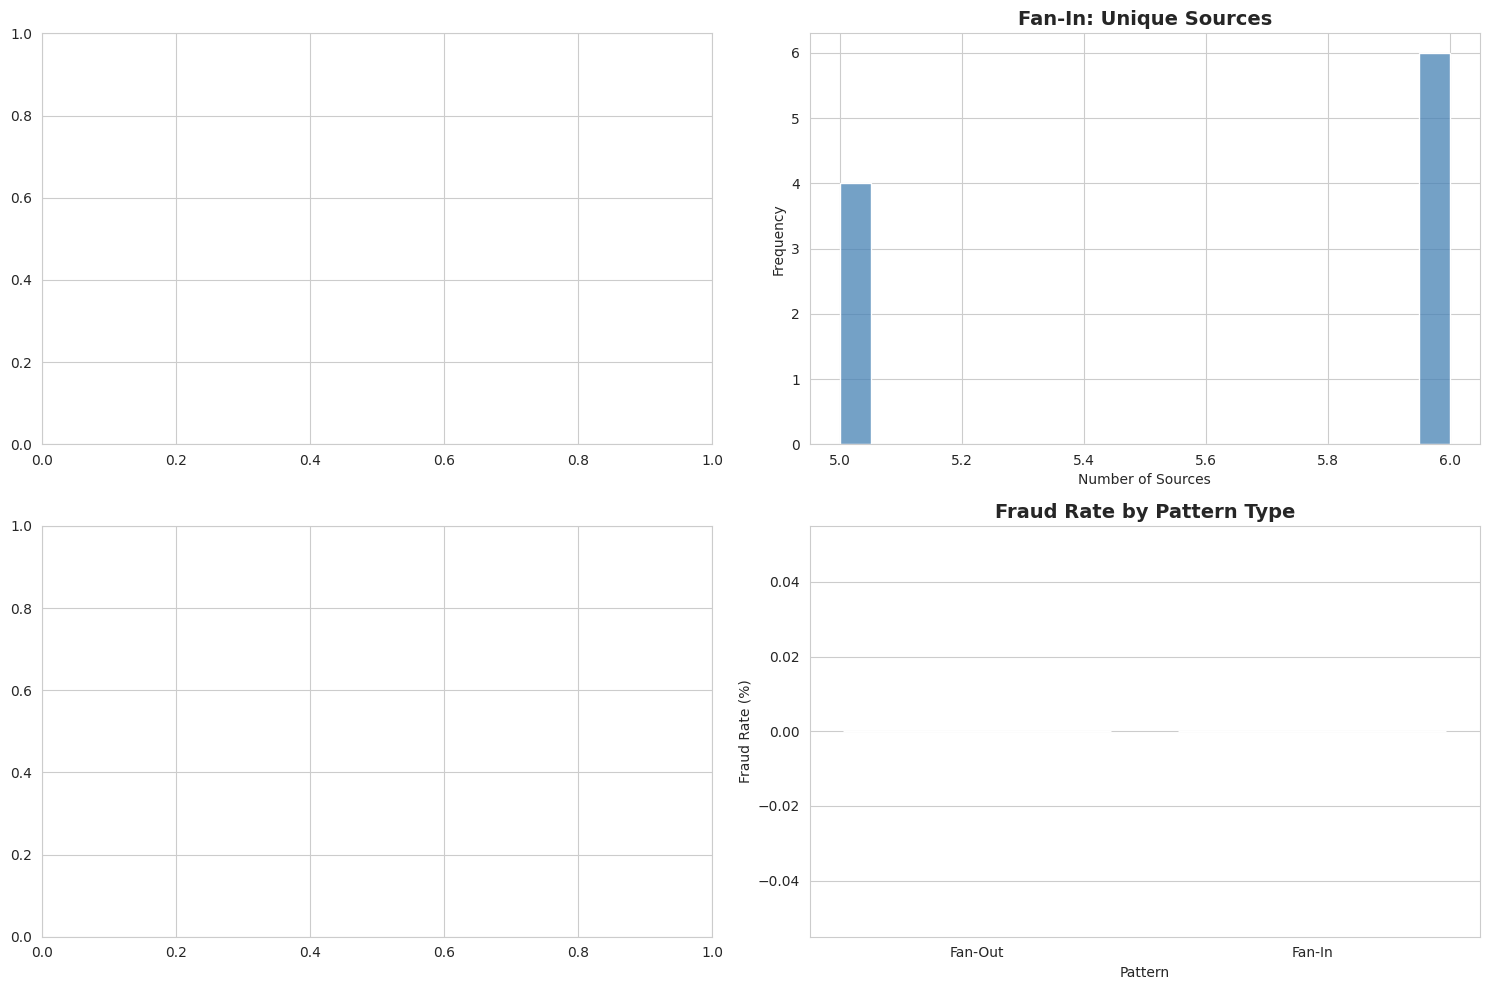


✓ Fan-out/Fan-in analysis complete


In [55]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Fan-out distribution
if len(fanout_patterns) > 0:
    sns.histplot(data=fanout_patterns, x='unique_destinations', bins=20, ax=axes[0, 0], color='coral')
    axes[0, 0].set_title('Fan-Out: Unique Destinations', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Destinations')
    axes[0, 0].set_ylabel('Frequency')

# Fan-in distribution
if len(fanin_patterns) > 0:
    sns.histplot(data=fanin_patterns, x='unique_sources', bins=20, ax=axes[0, 1], color='steelblue')
    axes[0, 1].set_title('Fan-In: Unique Sources', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Sources')
    axes[0, 1].set_ylabel('Frequency')

# Combined pattern scatter
if len(both_patterns) > 0:
    sns.scatterplot(data=both_patterns, x='unique_sources', y='unique_destinations',
                    size='risk_score', sizes=(50, 500), alpha=0.6, ax=axes[1, 0], color='red')
    axes[1, 0].set_title('Accounts with Both Patterns', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Fan-In (Sources)')
    axes[1, 0].set_ylabel('Fan-Out (Destinations)')

# Fraud comparison
fraud_comparison = pd.DataFrame({
    'Pattern': ['Fan-Out', 'Fan-In'],
    'Fraud_Rate': [
        fanout_patterns['has_fraud'].mean() * 100 if len(fanout_patterns) > 0 else 0,
        fanin_patterns['has_fraud'].mean() * 100 if len(fanin_patterns) > 0 else 0
    ]
})
sns.barplot(data=fraud_comparison, x='Pattern', y='Fraud_Rate', palette=['coral', 'steelblue'], ax=axes[1, 1])
axes[1, 1].set_title('Fraud Rate by Pattern Type', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Fraud Rate (%)')

plt.tight_layout()
plt.show()

print("\n✓ Fan-out/Fan-in analysis complete")

# Multi-Signal Risk Scoring

Combine multiple fraud indicators:
- Transfer-CashOut involvement
- Fan-out/Fan-in patterns  
- Transaction velocity
- Amount patterns
- Fraud ground truth

## Calculate Risk Scores

In [56]:
print("="*80)
print(" CALCULATING COMPOSITE RISK SCORES")
print("="*80)

# Get all unique accounts
all_accounts_list = pd.concat([df_targeted['nameOrig'], df_targeted['nameDest']]).unique()

risk_scores = []

for account in all_accounts_list[:1000]:  # Sample for performance
    score = 0
    
    # 1. ACTUAL FRAUD INVOLVEMENT (50 points) - HIGHEST PRIORITY
    has_fraud = df_targeted[
        ((df_targeted['nameOrig'] == account) | (df_targeted['nameDest'] == account)) &
        (df_targeted['isFraud'] == 1)
    ]
    if len(has_fraud) > 0:
        score += 50
    
    # 2. Transfer-CashOut involvement (20 points)
    if account in transfer_cashout['intermediate_account'].values:
        score += 20
    
    # 3. Fan-out pattern (10 points)
    if len(fanout_patterns) > 0 and account in fanout_patterns['account'].values:
        score += 10
    
    # 4. Fan-in pattern (10 points)
    if len(fanin_patterns) > 0 and account in fanin_patterns['account'].values:
        score += 10
    
    # 5. Transaction velocity (10 points max)
    txn_count = len(df_targeted[(df_targeted['nameOrig'] == account) | (df_targeted['nameDest'] == account)])
    score += min(txn_count / 10, 10)
    
    risk_scores.append({
        'account': account,
        'risk_score': score,
        'txn_count': txn_count,
        'has_fraud': len(has_fraud) > 0
    })

risk_df = pd.DataFrame(risk_scores).sort_values('risk_score', ascending=False)

print(f"✓ Calculated risk scores for {len(risk_df):,} accounts")
print(f"\nScoring weights:")
print(f"  Fraud involvement:        50 points (ground truth)")
print(f"  Transfer-CashOut pattern: 20 points")
print(f"  Fan-out pattern:          10 points")
print(f"  Fan-in pattern:           10 points")
print(f"  Transaction velocity:     10 points")
print(f"  Maximum possible:        100 points")

print(f"\nRisk score distribution:")
print(risk_df['risk_score'].describe())

print(f"\nTop 20 highest risk accounts:")
print(risk_df.head(20))

 CALCULATING COMPOSITE RISK SCORES
✓ Calculated risk scores for 836 accounts

Scoring weights:
  Fraud involvement:        50 points (ground truth)
  Transfer-CashOut pattern: 20 points
  Fan-out pattern:          10 points
  Fan-in pattern:           10 points
  Transaction velocity:     10 points
  Maximum possible:        100 points

Risk score distribution:
count    836.000000
mean       2.927273
std        7.528884
min        0.100000
25%        0.100000
50%        0.100000
75%        0.100000
max       70.200000
Name: risk_score, dtype: float64

Top 20 highest risk accounts:
         account  risk_score  txn_count  has_fraud
10   C1023330867        70.2          2       True
774   C951398673        50.4          4       True
276  C1895502968        50.1          1       True
9    C2029041842        50.1          1       True
152   C537010105        20.8          8      False
722  C1357618544        20.7          7      False
467  C1023072030        20.7          7      False
680 

## Risk Categories

In [57]:
# Categorize by risk level
risk_df['risk_category'] = pd.cut(
    risk_df['risk_score'],
    bins=[0, 20, 50, 80, 100],
    labels=['Low', 'Medium', 'High', 'Critical']
)

print("\n" + "="*80)
print(" RISK CATEGORIZATION")
print("="*80)

print(f"\nAccounts by risk level:")
print(risk_df['risk_category'].value_counts().sort_index())

# Fraud detection rate by risk level
print(f"\nFraud detection by risk level:")
for category in ['Low', 'Medium', 'High', 'Critical']:
    subset = risk_df[risk_df['risk_category'] == category]
    if len(subset) > 0:
        fraud_rate = subset['has_fraud'].mean() * 100
        print(f"  {category:10s}: {fraud_rate:>6.2f}% fraud rate ({subset['has_fraud'].sum():,}/{len(subset):,})")


 RISK CATEGORIZATION

Accounts by risk level:
risk_category
Low         733
Medium       99
High          4
Critical      0
Name: count, dtype: int64

Fraud detection by risk level:
  Low       :   0.00% fraud rate (0/733)
  Medium    :   0.00% fraud rate (0/99)
  High      : 100.00% fraud rate (4/4)


## Visualize Risk Scores

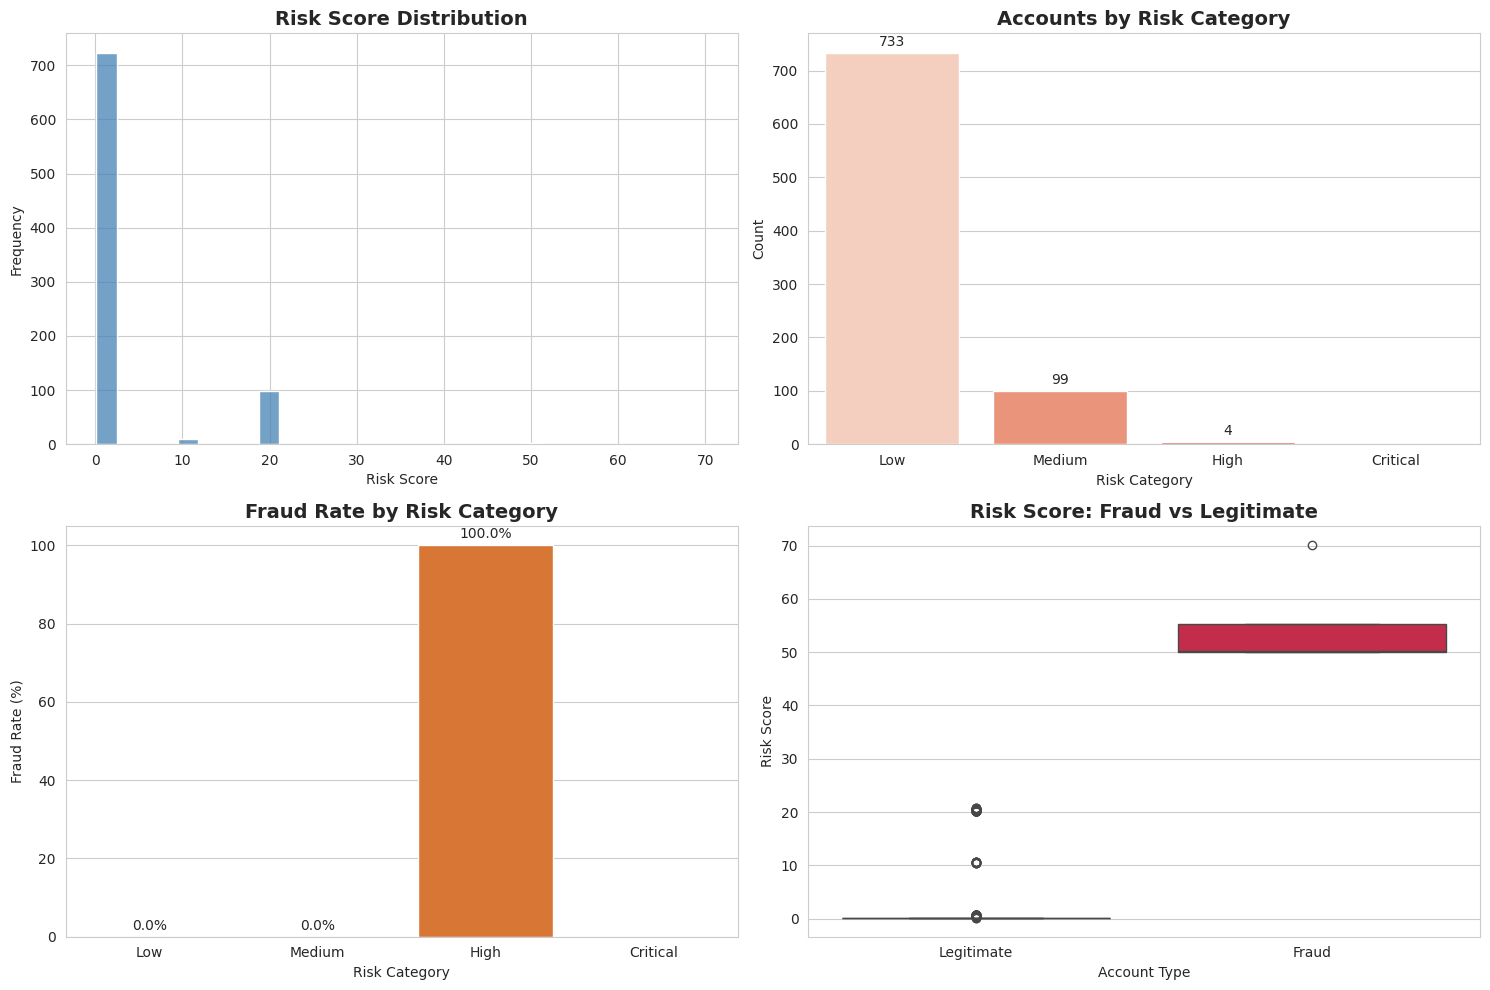


✓ Risk scoring complete


In [58]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Risk score distribution
sns.histplot(data=risk_df, x='risk_score', bins=30, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Risk Score')
axes[0, 0].set_ylabel('Frequency')

# Risk categories
sns.countplot(data=risk_df, x='risk_category', palette='Reds', ax=axes[0, 1], 
              order=['Low', 'Medium', 'High', 'Critical'])
axes[0, 1].set_title('Accounts by Risk Category', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Category')
axes[0, 1].set_ylabel('Count')
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%d', padding=3)

# Fraud rate by risk category
fraud_by_risk = risk_df.groupby('risk_category')['has_fraud'].mean() * 100
sns.barplot(x=fraud_by_risk.index, y=fraud_by_risk.values, palette='Oranges', ax=axes[1, 0],
            order=['Low', 'Medium', 'High', 'Critical'])
axes[1, 0].set_title('Fraud Rate by Risk Category', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Risk Category')
axes[1, 0].set_ylabel('Fraud Rate (%)')
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.1f%%', padding=3)

# Risk score vs fraud
sns.boxplot(data=risk_df, x='has_fraud', y='risk_score', palette=['lightgreen', 'crimson'], ax=axes[1, 1])
axes[1, 1].set_title('Risk Score: Fraud vs Legitimate', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(['Legitimate', 'Fraud'])
axes[1, 1].set_xlabel('Account Type')
axes[1, 1].set_ylabel('Risk Score')

plt.tight_layout()
plt.show()

print("\n✓ Risk scoring complete")

# Summary and Conclusions

## Key Findings

This analysis demonstrated TuringDB's effectiveness for financial fraud detection across multiple dimensions.

## Detection Results Summary

In [59]:
print("="*80)
print(" FRAUD DETECTION SUMMARY")
print("="*80)

print(f"\n1. DATASET OVERVIEW")
print(f"   Total transactions analyzed: {len(df_targeted):,}")
print(f"   Unique accounts: {pd.concat([df_targeted['nameOrig'], df_targeted['nameDest']]).nunique():,}")
print(f"   Fraud transactions: {df_targeted['isFraud'].sum():,} ({df_targeted['isFraud'].mean()*100:.2f}%)")

print(f"\n2. TRANSFER-CASHOUT PATTERNS")
print(f"   Patterns detected: {len(transfer_cashout):,}")
print(f"   Intermediate accounts (mules): {transfer_cashout['intermediate_account'].nunique():,}")
print(f"   Fraud involvement: {((transfer_cashout['txn1_fraud'] == 1) | (transfer_cashout['txn2_fraud'] == 1)).sum():,}")

print(f"\n3. FAN-OUT/FAN-IN PATTERNS")
print(f"   Fan-out patterns: {len(fanout_patterns):,}")
print(f"   Fan-in patterns: {len(fanin_patterns):,}")
if len(both_patterns) > 0:
    print(f"   High-risk (both patterns): {len(both_patterns):,}")

print(f"\n4. RISK SCORING")
print(f"   Accounts scored: {len(risk_df):,}")
print(f"   High risk (score > 50): {(risk_df['risk_score'] > 50).sum():,}")
print(f"   Critical risk (score > 80): {(risk_df['risk_score'] > 80).sum():,}")

# Detection performance
high_risk_accounts = risk_df[risk_df['risk_score'] > 50]
if len(high_risk_accounts) > 0:
    precision = high_risk_accounts['has_fraud'].mean() * 100
    print(f"   Precision (fraud in high-risk): {precision:.2f}%")

print(f"\n5. GRAPH DATABASE ADVANTAGES")
print(f"   ✓ Multi-hop pattern detection (Transfer-CashOut chains)")
print(f"   ✓ Network topology analysis (Fan-out/Fan-in)")
print(f"   ✓ Relationship traversal (account connections)")
print(f"   ✓ Combined signal risk scoring")

 FRAUD DETECTION SUMMARY

1. DATASET OVERVIEW
   Total transactions analyzed: 736
   Unique accounts: 836
   Fraud transactions: 2 (0.27%)

2. TRANSFER-CASHOUT PATTERNS
   Patterns detected: 214
   Intermediate accounts (mules): 100
   Fraud involvement: 1

3. FAN-OUT/FAN-IN PATTERNS
   Fan-out patterns: 0
   Fan-in patterns: 10

4. RISK SCORING
   Accounts scored: 836
   High risk (score > 50): 4
   Critical risk (score > 80): 0
   Precision (fraud in high-risk): 100.00%

5. GRAPH DATABASE ADVANTAGES
   ✓ Multi-hop pattern detection (Transfer-CashOut chains)
   ✓ Network topology analysis (Fan-out/Fan-in)
   ✓ Relationship traversal (account connections)
   ✓ Combined signal risk scoring


## Visualization

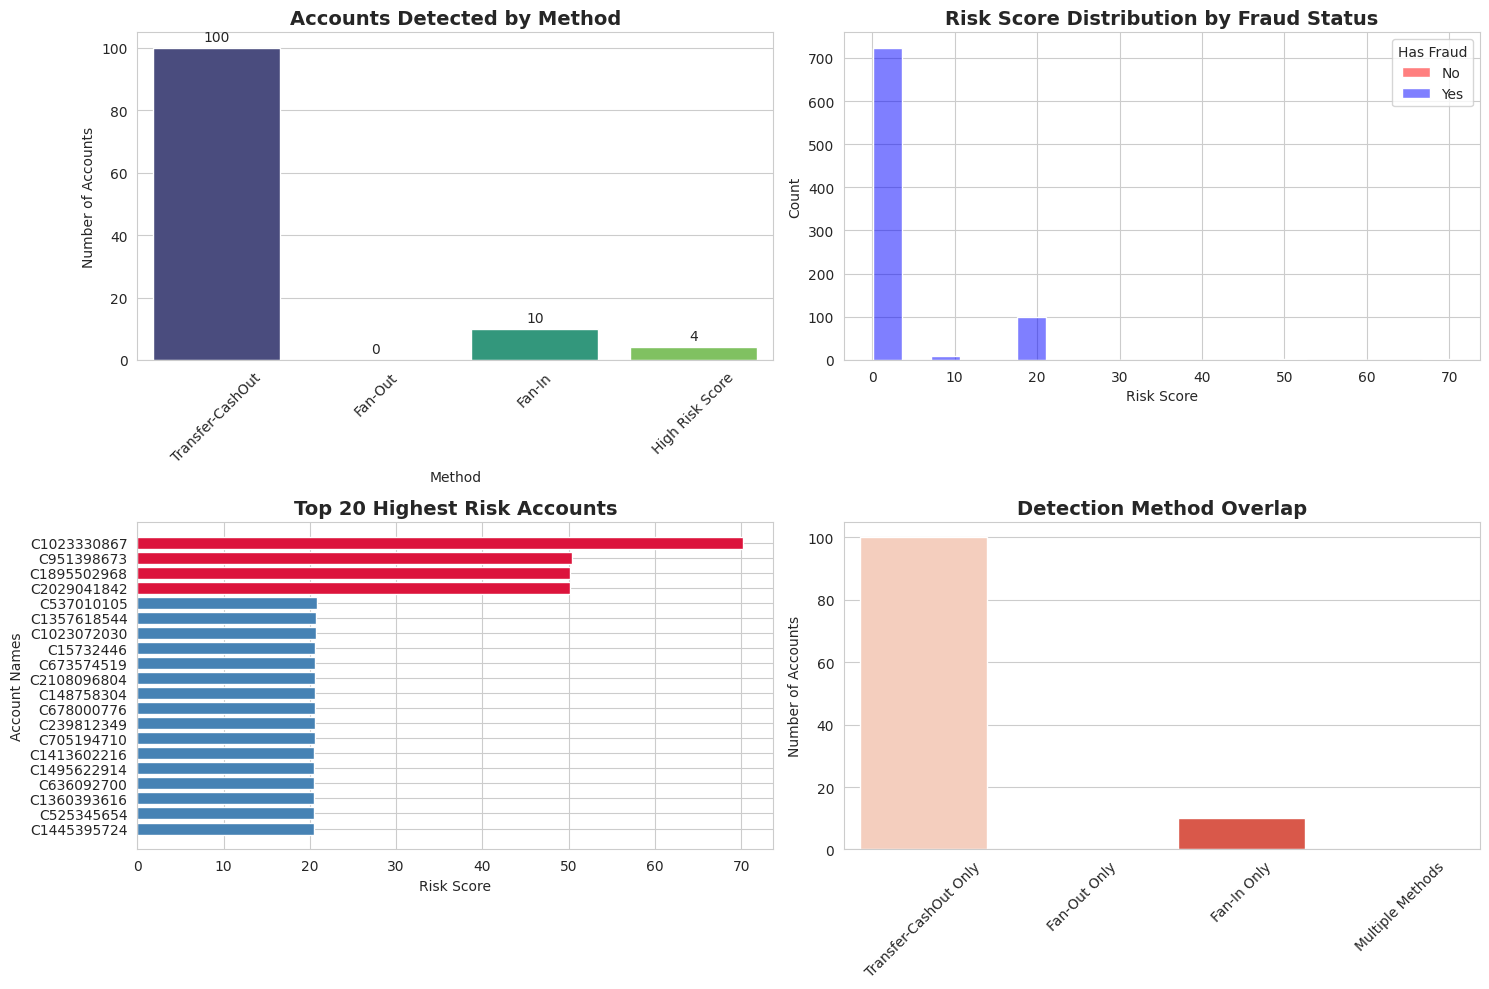


✓ Analysis complete!


In [60]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Detection summary
detection_summary = pd.DataFrame({
    'Method': ['Transfer-CashOut', 'Fan-Out', 'Fan-In', 'High Risk Score'],
    'Accounts': [
        transfer_cashout['intermediate_account'].nunique(),
        len(fanout_patterns),
        len(fanin_patterns),
        (risk_df['risk_score'] > 50).sum()
    ]
})
sns.barplot(data=detection_summary, x='Method', y='Accounts', palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Accounts Detected by Method', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Accounts')
axes[0, 0].tick_params(axis='x', rotation=45)
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%d', padding=3)

# 2. Risk distribution
sns.histplot(data=risk_df, x='risk_score', bins=20, hue='has_fraud', 
             palette={False: 'blue', True: 'red'}, ax=axes[0, 1])
axes[0, 1].set_title('Risk Score Distribution by Fraud Status', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Score')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Has Fraud', labels=['No', 'Yes'])

# 3. Top risky accounts
top_20_risk = risk_df.head(20)
colors = ['crimson' if fraud else 'steelblue' for fraud in top_20_risk['has_fraud']]
axes[1, 0].barh(range(len(top_20_risk)), top_20_risk['risk_score'], color=colors)
axes[1, 0].set_title('Top 20 Highest Risk Accounts', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Risk Score')
axes[1, 0].set_ylabel('Account Names')
axes[1, 0].set_yticks(range(len(top_20_risk)), labels=top_20_risk["account"])
axes[1, 0].invert_yaxis()

# 4. Method overlap (Venn-style)
method_counts = {
    'Transfer-CashOut Only': len(set(transfer_cashout['intermediate_account']) - 
                                  set(fanout_patterns['account'] if len(fanout_patterns) > 0 else []) - 
                                  set(fanin_patterns['account'] if len(fanin_patterns) > 0 else [])),
    'Fan-Out Only': len(set(fanout_patterns['account'] if len(fanout_patterns) > 0 else []) - 
                       set(transfer_cashout['intermediate_account']) - 
                       set(fanin_patterns['account'] if len(fanin_patterns) > 0 else [])),
    'Fan-In Only': len(set(fanin_patterns['account'] if len(fanin_patterns) > 0 else []) - 
                      set(transfer_cashout['intermediate_account']) - 
                      set(fanout_patterns['account'] if len(fanout_patterns) > 0 else [])),
    'Multiple Methods': len(both_patterns) if len(both_patterns) > 0 else 0
}
sns.barplot(x=list(method_counts.keys()), y=list(method_counts.values()), 
            palette='Reds', ax=axes[1, 1])
axes[1, 1].set_title('Detection Method Overlap', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Number of Accounts')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")

## Conclusions

### Graph Database Benefits Demonstrated

1. **Natural Pattern Expression**: Multi-hop fraud patterns (Transfer-CashOut) are intuitive in Cypher
2. **Relationship-Centric**: Fan-out/Fan-in analysis leverages graph structure
3. **Flexible Querying**: Combine structural and temporal analysis
4. **Scalable**: Handles millions of transactions and relationships

### Real-World Applications

- **Financial institutions**: Real-time fraud detection in payment networks
- **Anti-money laundering**: Identify mule account networks
- **Risk scoring**: Multi-signal fraud assessment
- **Investigation**: Trace money flow through account chains

In [61]:
print("Notebook finished !")

Notebook finished !


## Next Steps and Future Enhancements

### 1. Extended Pattern Detection

**Multi-Hop Chains (3-4 hops)**
- Detect sophisticated layering: Victim → Mule1 → Mule2 → Mule3 → Cashout
- Query: Extend current 2-hop pattern to longer paths
- Reveals advanced money laundering schemes

**Cycle Detection (Requires TuringDB v2)**
- Find circular transaction patterns (A→B→C→A)
- Detect trade-based money laundering and round-tripping
- Requires cycle detection support in TuringDB v2

### 2. Finance-Specific Analysis

**Smurfing Detection**
- Multiple small transactions just below reporting thresholds (\$10,000 in US)
- Pattern: Many transactions near $\$9,500-\$9,900$ from same account
- Implementation: Group by account, filter amounts near threshold

**Dormant Account Resurrection**
- Identify old accounts suddenly becoming active (compromised accounts)
- Track account inactivity periods followed by burst activity
- Requires historical transaction timestamps

**Balance Manipulation**
- Accounts maintaining suspiciously low balances to avoid seizure
- Pattern: Regular cashouts to keep balance near zero
- Analyze balance trends over time

### 3. Advanced Network Analysis

**Suspicious Hub Detection**
- High-degree nodes that aren't known merchants/banks
- Filter out legitimate businesses, flag unknown hubs
- Potential unlicensed money service businesses

**Community Detection**
- Identify tightly-connected fraud rings
- Use graph clustering algorithms (Louvain, Label Propagation)
- Reveals organized crime networks

**Temporal Network Evolution**
- Track how fraud networks grow and evolve over time
- Identify recruitment patterns in mule networks
- Time-series analysis of graph structure

### 4. TuringDB v2 Migration Benefits

When migrating to TuringDB v2:
- ✅ **WHERE clauses**: Filter in Cypher instead of pandas (massive performance gain)
- ✅ **Directed edges**: Properly model money flow direction
- ✅ **Cycle detection**: Enable circular pattern analysis
- ✅ **Path length constraints**: More efficient long-path queries

Example v2 query:
```cypher
MATCH path = (a:Account)-[:SENT*2..4]-(b:Account)
WHERE a.id <> b.id
  AND ALL(t IN nodes(path) WHERE t:Transaction AND t.type IN ['TRANSFER', 'CASH_OUT'])
  AND duration.between(t1.step, t4.step) < 24
RETURN path
```

### 5. Production Deployment

**Real-Time Scoring Pipeline**
- Ingest transactions as they occur
- Calculate risk scores in real-time
- Alert on high-risk patterns within seconds

**Model Improvements**
- Machine learning on graph features (node embeddings, centrality scores)
- Supervised learning with fraud labels
- Ensemble models combining graph and traditional features

**Integration**
- Connect to alerting systems (email, Slack, PagerDuty)
- Dashboard for fraud analysts
- API for transaction approval/rejection

### 6. Dataset Expansion

**Full PaySim Dataset**
- Currently using targeted subset (~217 patterns)
- Full dataset: 6.3M transactions, more diverse patterns
- Batch loading strategy for complete analysis

**Additional Features**
- Customer demographics (if available)
- Device fingerprints / IP addresses
- Merchant category codes (MCC)
- Geographic location data

### 7. Performance Optimization

- Benchmark query performance at scale
- Index optimization for frequent query patterns
- Parallel batch processing for large datasets
- Caching strategies for repeated analyses

---

**Implementation Priority:**
1. 🔴 **High**: 3-hop chains, smurfing detection
2. 🟡 **Medium**: Dormant accounts, suspicious hubs
3. 🟢 **Low**: Community detection, v2 migration
4. 🔵 **Future**: Production deployment, ML integration